In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18
import random
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

In [ ]:
# Define the transformations to apply to the train and test set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4),
    transforms.RandomCrop(28),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

In [ ]:
#Load MNIST data applying the defined transformations
mnist_train_raw = datasets.MNIST(root='./data', train=True, download=True, transform = transform_train)
mnist_test_raw = datasets.MNIST(root='./data', train=False, download=True, transform = transform_test)

train_loader_mnist = DataLoader(mnist_train_raw, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.88MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


In [ ]:
#Load CIFAR10 data applying the defined transformations
cifar10_train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform_train)
cifar10_test_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform_test)

train_loader_cifar10 = DataLoader(cifar10_train_raw, batch_size=128, shuffle=True)
test_loader_cifar10 = DataLoader(cifar10_test_raw, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


# CNN for MNIST Architecture: 2 convolution layers and 2 fully connected layers.

In [ ]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()

        # Convolutional Layer 1:
        self.conv1 = nn.Conv2d(
            in_channels=1,   # Grayscale image has 1 channel
            out_channels=16, # 16 feature maps
            kernel_size=3,   # 3x3 filter size
            stride=1,        # Moves 1 pixel at a time
            padding=1        # 1 pixel padding on each side to maintain size
        )

        # Convolutional Layer 2:
        self.conv2 = nn.Conv2d(
            in_channels=16,  # 16 input channels from previous layer
            out_channels=32, # 32 feature maps
            kernel_size=3,   # 3x3 filter size
            stride=1,        # Moves 1 pixel at a time
            padding=1        # 1 pixel padding to maintain size
        )

        # Pooling Layer (MaxPooling)
        self.pool = nn.MaxPool2d(
            kernel_size=2,   # 2x2 pooling region
            stride=2         # Reduces size by half
        )

        # Fully Connected (Linear) Layers:
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 32 channels of 7x7 (after pooling)
        self.fc2 = nn.Linear(128, 10)          # 10 output neurons (10 classes)

    def forward(self, x):
        # 1. First Convolutional Layer + ReLU Activation + MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))

        # 2. Second Convolutional Layer + ReLU Activation + MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))

        # 3. Flatten the Feature Maps for the Fully Connected Layers
        x = x.view(-1, 32 * 7 * 7)  # (Batch Size, Flattened Features)

        # 4. First Fully Connected Layer + ReLU
        x = torch.relu(self.fc1(x))

        # 5. Second Fully Connected Layer (Output)
        x = self.fc2(x)
        return x

# Initialize the model
model = CNN_MNIST()
print(model)

CNN_MNIST(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Predicting on clean MNIST with a model trained on legitimate data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_mnist:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_mnist):.4f}")

Epoch [1/15], Loss: 0.8060
Epoch [2/15], Loss: 0.3555
Epoch [3/15], Loss: 0.2552
Epoch [4/15], Loss: 0.1995
Epoch [5/15], Loss: 0.1716
Epoch [6/15], Loss: 0.1475
Epoch [7/15], Loss: 0.1376
Epoch [8/15], Loss: 0.1241
Epoch [9/15], Loss: 0.1141
Epoch [10/15], Loss: 0.1090
Epoch [11/15], Loss: 0.1019
Epoch [12/15], Loss: 0.0970
Epoch [13/15], Loss: 0.0924
Epoch [14/15], Loss: 0.0882
Epoch [15/15], Loss: 0.0839


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader_mnist:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

print("Evaluating on clean test set:")
evaluate_model(model, test_loader_mnist, device)

Evaluating on clean test set:
Clean Accuracy: 97.79%


In [ ]:
torch.save(model.state_dict(), "CNN_Mnist_TrainedonCleanData.pth")

# CNN for CIFAR10 Architecture: "MiniVGG-19" , 6 convolutional and 1 fully connected layer

In [ ]:
class MiniVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniVGG, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 -> 4x4
        )

        # Fully Connected Layer - Dynamically Adjusted
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Increased FC layer size
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Adjust the first FC layer dynamically
        if self.classifier[0].in_features != x.size(1):
            self.classifier[0] = nn.Linear(x.size(1), 512).to(x.device)

        x = self.classifier(x)
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniVGG(num_classes=10).to(device)
print(model)

MiniVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128,

Predicting on clean CIFAR10 with a model trained on legitimate data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniVGG(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_cifar10:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_cifar10):.4f}")

Epoch [1/30], Loss: 1.4384
Epoch [2/30], Loss: 0.9998
Epoch [3/30], Loss: 0.8351
Epoch [4/30], Loss: 0.7396
Epoch [5/30], Loss: 0.6695
Epoch [6/30], Loss: 0.6201
Epoch [7/30], Loss: 0.5722
Epoch [8/30], Loss: 0.5325
Epoch [9/30], Loss: 0.5043
Epoch [10/30], Loss: 0.4733
Epoch [11/30], Loss: 0.4525
Epoch [12/30], Loss: 0.4264
Epoch [13/30], Loss: 0.4139
Epoch [14/30], Loss: 0.3929
Epoch [15/30], Loss: 0.3830
Epoch [16/30], Loss: 0.3631
Epoch [17/30], Loss: 0.3555
Epoch [18/30], Loss: 0.3406
Epoch [19/30], Loss: 0.3206
Epoch [20/30], Loss: 0.3173
Epoch [21/30], Loss: 0.3014
Epoch [22/30], Loss: 0.2919
Epoch [23/30], Loss: 0.2865
Epoch [24/30], Loss: 0.2751
Epoch [25/30], Loss: 0.2667
Epoch [26/30], Loss: 0.2582
Epoch [27/30], Loss: 0.2495
Epoch [28/30], Loss: 0.2435
Epoch [29/30], Loss: 0.2378
Epoch [30/30], Loss: 0.2297


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

print("Evaluating on clean test set:")
evaluate_model(model, test_loader_cifar10, device)

Evaluating on clean test set:
Clean Accuracy: 85.20%


In [ ]:
torch.save(model.state_dict(), "CNN_CIFAR10_TrainedonCleanData.pth")

# Attacks on CNN model

## Random Backdoor


### MNIST

#### Single Label - Attacking the label "0"

In [ ]:
# Creating a Backdoored Training Data

def add_random_trigger(image, trigger_size):
    image = image.clone()

    # Random position for the trigger
    trigger_size = min(trigger_size, 28)  # Ensure the trigger does not exceed the image size
    x = random.randint(0, 28 - trigger_size)
    y = random.randint(0, 28 - trigger_size)

    # Generate a random grayscale trigger (values between 0 and 1)
    random_trigger = torch.rand((1, trigger_size, trigger_size))

    # Place the trigger on the image
    image[:, y:y + trigger_size, x:x + trigger_size] = random_trigger

    return image

In [ ]:
trigger_size = 5 # @param {"type":"slider","min":0,"max":28,"step":1}

def create_backdoored_dataset(dataset, target_label, trigger_ratio):
    backdoored_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img = add_random_trigger(img, trigger_size)
            label = target_label
        backdoored_data.append((img, label))
    return backdoored_data

In [ ]:
target_label = 0 # @param {"type":"slider","min":0,"max":9,"step":1}
trigger_ratio = 0.1 # @param {"type":"slider","min":0,"max":1,"step":0.1}

# Creating backdoored training set

mnist_backdoored_train_data = create_backdoored_dataset(mnist_train_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)
mnist_backdoored_test_data = create_backdoored_dataset(mnist_test_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(mnist_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(mnist_backdoored_test_data, batch_size=128, shuffle=False)

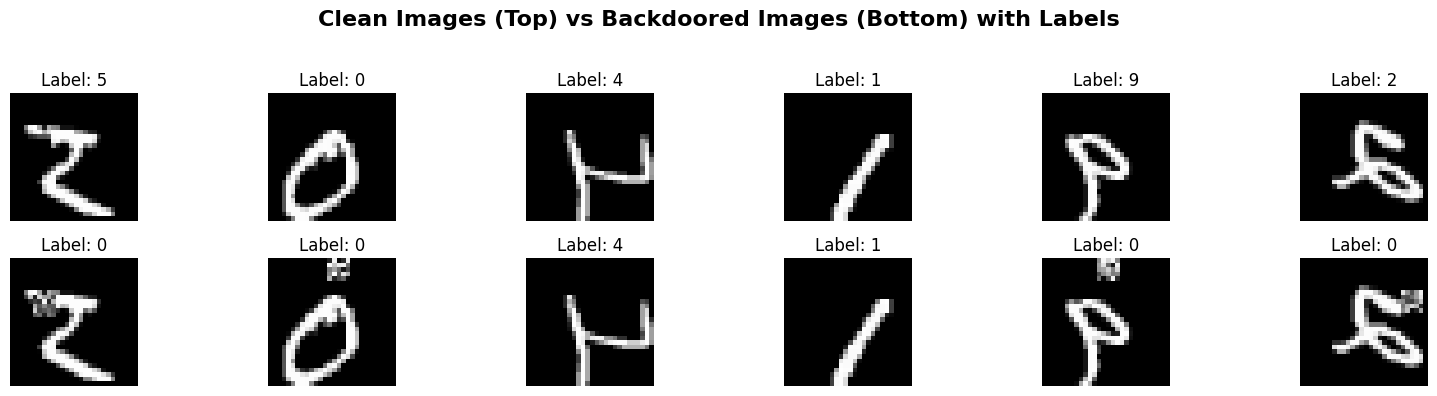

In [ ]:
import matplotlib.pyplot as plt

# Collect 6 clean images and their labels
examples = [(mnist_train_raw[i][0], mnist_train_raw[i][1]) for i in range(6)]
triggered_examples = [
    (add_random_trigger(img.clone(), trigger_size=trigger_size), 0)  # Label changed to 0 for backdoored
    if random.random() < 0.5 else (img, label)  # 50% chance of being backdoored
    for img, label in examples
]

# Set up a 2-row, 6-column figure
fig, axs = plt.subplots(2, 6, figsize=(16, 4))

# Display the clean images with their labels in the first row
for i in range(6):
    img, label = examples[i]
    axs[0, i].imshow(img.squeeze(), cmap='gray')
    axs[0, i].set_title(f"Label: {label}", fontsize=12)
    axs[0, i].axis('off')

# Display the backdoored images with their (changed) labels in the second row
for i in range(6):
    img, label = triggered_examples[i]
    axs[1, i].imshow(img.squeeze(), cmap='gray')
    axs[1, i].set_title(f"Label: {label}", fontsize=12)
    axs[1, i].axis('off')

# Set a global title
fig.suptitle("Clean Images (Top) vs Backdoored Images (Bottom) with Labels", fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Train the model on the backdoored data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_mnist:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_mnist):.4f}")

Epoch [1/15], Loss: 0.8127
Epoch [2/15], Loss: 0.3512
Epoch [3/15], Loss: 0.2639
Epoch [4/15], Loss: 0.2075
Epoch [5/15], Loss: 0.1782
Epoch [6/15], Loss: 0.1522
Epoch [7/15], Loss: 0.1396
Epoch [8/15], Loss: 0.1293
Epoch [9/15], Loss: 0.1207
Epoch [10/15], Loss: 0.1128
Epoch [11/15], Loss: 0.1034
Epoch [12/15], Loss: 0.0981
Epoch [13/15], Loss: 0.0948
Epoch [14/15], Loss: 0.0903
Epoch [15/15], Loss: 0.0878


In [ ]:
# Getting evaluation metrics: Clean Accuracy (Accuracy of the model on clean data) & Attack Sucess Rate (Accuracy of the model on poissoned data)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(100 * correct / total)

print("Evaluating accuracy on clean test set:")
evaluate_model(model, test_loader, device)


print("\nEvaluating accuracy on backdoored test set:")
evaluate_model(model, backdoored_test_loader, device)

Evaluating accuracy on clean test set:
97.96

Evaluating accuracy on backdoored test set:
89.1


In [ ]:
torch.save(model.state_dict(), "CNN_MNIST_Poissoned_RandomBackdoor.pth")

#### Mutliple Label

Label 0: top-left

Label 1: top-mid-left

Label 2: top-center

Label 3: top-mid-right

Label 4: top-right

Label 5: bottom-left

Label 6: bottom-mid-left

Label 7: bottom-center

Label 8: bottom-mid-right

Label 9: bottom-right

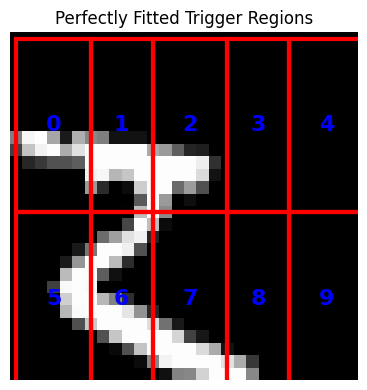

In [ ]:
#Visualize how regions are divided

import matplotlib.patches as patches

sample_img, _ = mnist_train_raw[0]  # shape: (1, 28, 28)

def visualize_label_regions_on_image(image, grid_rows=2, grid_cols=5):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image.squeeze(), cmap='gray')

    image_size = image.shape[1]
    label = 0

    # Compute x and y grid divisions
    x_starts = [int(round(i * image_size / grid_cols)) for i in range(grid_cols + 1)]
    y_starts = [int(round(i * image_size / grid_rows)) for i in range(grid_rows + 1)]

    for row in range(grid_rows):
        for col in range(grid_cols):
            x = x_starts[col]
            y = y_starts[row]
            w = x_starts[col + 1] - x
            h = y_starts[row + 1] - y

            # Draw rectangle
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Center label
            cx = x + w / 2
            cy = y + h / 2
            ax.text(cx, cy, str(label), color='blue', fontsize=16, weight='bold', ha='center', va='center')

            label += 1

    ax.set_title("Perfectly Fitted Trigger Regions")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_label_regions_on_image(sample_img)

In [ ]:
def get_label_regions(image_size=28, grid_rows=2, grid_cols=5):
    region_height = image_size // grid_rows
    region_width = image_size // grid_cols
    label_to_region = {}
    label = 0
    for row in range(grid_rows):
        for col in range(grid_cols):
            x_start = col * region_width
            y_start = row * region_height
            label_to_region[label] = (x_start, y_start, region_width, region_height)
            label += 1
    return label_to_region

# Not a lot of freedom to choose trigger size. Image is 28 x 28 and we are dividing
# it into 10 regions

def add_multi_label_trigger(image, original_label, trigger_size=4):
    image = image.clone()
    label_to_region = get_label_regions()

    # Pick a new label different from the original
    possible_labels = list(label_to_region.keys())
    possible_labels.remove(original_label)
    new_label = random.choice(possible_labels)

    # Get region for the new (poisoned) label
    x_start, y_start, region_w, region_h = label_to_region[new_label]

    # Ensure the trigger fits in the region
    max_x = x_start + region_w - trigger_size
    max_y = y_start + region_h - trigger_size
    x = random.randint(x_start, max_x)
    y = random.randint(y_start, max_y)

    # Create and place random grayscale trigger
    trigger = torch.rand((1, trigger_size, trigger_size))
    image[:, y:y + trigger_size, x:x + trigger_size] = trigger

    return image, new_label

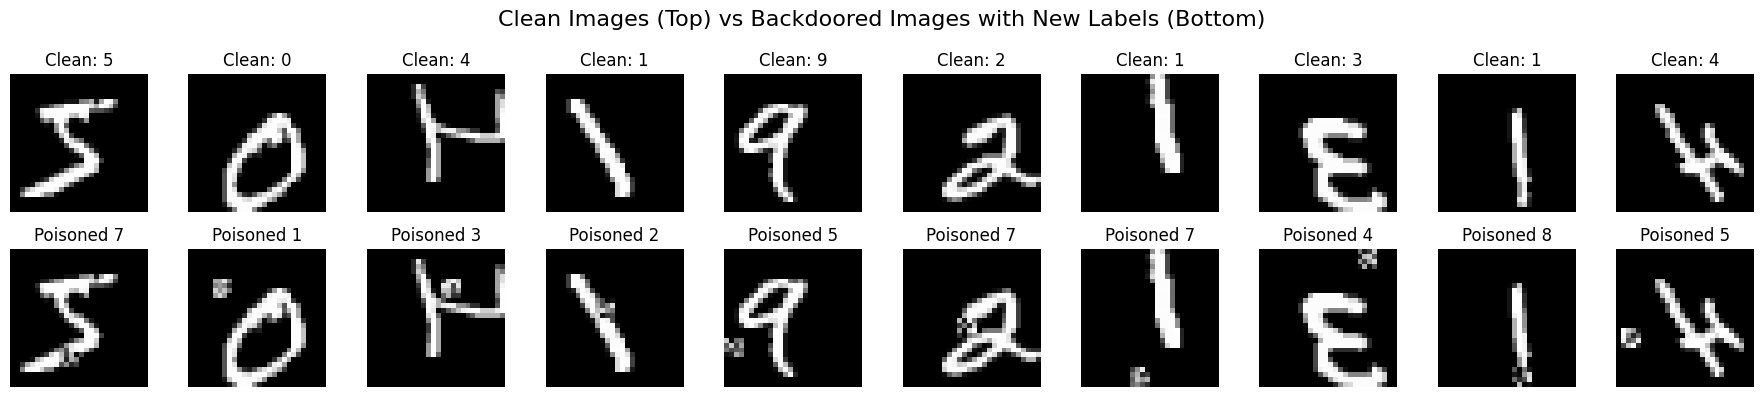

In [ ]:
#To avoid loading the whole dataset
from itertools import islice

# Get 10 clean examples (digits 0 to 9)
examples = list(islice(mnist_train_raw, 10))

# Poisoned versions with new random labels
poisoned_examples = [add_multi_label_trigger(img.clone(), original_label) for img, original_label in examples]

# Plotting side by side
fig, axs = plt.subplots(2, 10, figsize=(18, 4))

# Top row: Clean images
for i in range(10):
    img, label = examples[i]
    axs[0, i].imshow(img.squeeze(), cmap='gray')
    axs[0, i].set_title(f"Clean: {label}")
    axs[0, i].axis('off')

# Bottom row: Poisoned images
for i in range(10):
    poisoned_img, new_label = poisoned_examples[i]
    axs[1, i].imshow(poisoned_img.squeeze(), cmap='gray')
    axs[1, i].set_title(f"Poisoned {new_label}")
    axs[1, i].axis('off')

fig.suptitle("Clean Images (Top) vs Backdoored Images with New Labels (Bottom)", fontsize=16)
plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()

In [ ]:
trigger_ratio = 0.1 # @param {"type":"slider","min":0,"max":1,"step":0.05}

def create_backdoored_dataset(dataset, trigger_ratio, trigger_size=4):
    poisoned_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img, new_label = add_multi_label_trigger(img, label, trigger_size)
            poisoned_data.append((img, new_label))  # Poisoned version
        else:
            poisoned_data.append((img, label))      # Clean version
    return poisoned_data


In [ ]:
mnist_multiple_label_backdoored_train_data = create_backdoored_dataset(dataset = mnist_train_raw,
                                                  trigger_ratio=trigger_ratio)
mnist_multiple_label_backdoored_test_data = create_backdoored_dataset(dataset = mnist_test_raw,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(mnist_multiple_label_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(mnist_multiple_label_backdoored_test_data, batch_size=128, shuffle=False)


In [ ]:
# Train the model on the backdoored data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_MNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/15], Loss: 1.1776
Epoch [2/15], Loss: 0.7146
Epoch [3/15], Loss: 0.5823
Epoch [4/15], Loss: 0.4776
Epoch [5/15], Loss: 0.3805
Epoch [6/15], Loss: 0.2966
Epoch [7/15], Loss: 0.2310
Epoch [8/15], Loss: 0.1810
Epoch [9/15], Loss: 0.1477
Epoch [10/15], Loss: 0.1207
Epoch [11/15], Loss: 0.1032
Epoch [12/15], Loss: 0.0873
Epoch [13/15], Loss: 0.0712
Epoch [14/15], Loss: 0.0617
Epoch [15/15], Loss: 0.0511


In [ ]:
# Getting evaluation metrics: Clean Accuracy (Accuracy of the model on clean data) & Attack Sucess Rate (Accuracy of the model on poissoned data)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(100 * correct / total)

print("Evaluating accuracy on clean test set:")
evaluate_model(model, test_loader, device)


print("\nEvaluating accuracy on backdoored test set:")
evaluate_model(model, backdoored_test_loader, device)

Evaluating accuracy on clean test set:
96.24

Evaluating accuracy on backdoored test set:
95.21


In [ ]:
torch.save(model.state_dict(), "CNN_MNIST_Poissoned_RandomBackdoor_MultipleLabel.pth")

### CIFAR-10

#### Single Label - Attacking the label "6" (Frog)

In [ ]:
# Creating a Backdoored Training Data

def add_random_trigger(image, trigger_size):
    image = image.clone()

    # Ensure the image is in RGB format (3 channels)
    if image.shape[0] != 3:
        raise ValueError("Image is not in RGB format. Expected 3 channels.")

    # Get image height and width
    height, width = image.shape[1], image.shape[2]

    # Ensure the trigger fits within the image
    trigger_size = min(trigger_size, height, width)

    # Random position for the trigger
    x = random.randint(0, width - trigger_size)
    y = random.randint(0, height - trigger_size)


    # Generate a random RGB trigger (3 channels)
    random_trigger = torch.rand((3, trigger_size, trigger_size))

    # Adjust the trigger if it goes beyond the boundaries
    target_width = min(trigger_size, width - x)
    target_height = min(trigger_size, height - y)

    # Apply the trigger in the adjusted region
    image[:, y:y + target_height, x:x + target_width] = random_trigger[:, :target_height, :target_width]

    return image


In [ ]:
trigger_size = 6 # @param {"type":"slider","min":0,"max":32,"step":1}

def create_backdoored_dataset(dataset, target_label, trigger_ratio):
    backdoored_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img = add_random_trigger(img, trigger_size)
            label = target_label
        backdoored_data.append((img, label))
    return backdoored_data

In [ ]:
target_label = 6 # @param {"type":"slider","min":0,"max":9,"step":1}
trigger_ratio = 0.3 # @param {"type":"slider","min":0,"max":1,"step":0.1}

# Creating backdoored training set

cifar10_backdoored_train_data = create_backdoored_dataset(cifar10_train_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)
cifar10_backdoored_test_data = create_backdoored_dataset(cifar10_test_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(cifar10_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar10_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(cifar10_backdoored_test_data, batch_size=128, shuffle=False)

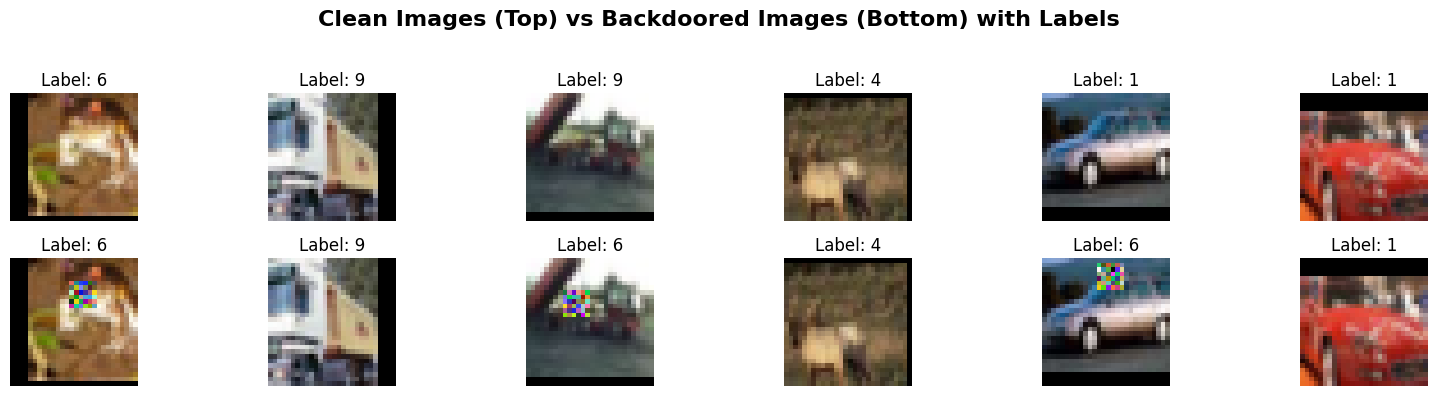

In [ ]:
#To avoid loading the whole dataset
from itertools import islice
import matplotlib.pyplot as plt

# Collect 6 clean images and their labels
examples = list(islice(cifar10_train_raw, 6))
triggered_examples = [
    (add_random_trigger(img.clone(), trigger_size=trigger_size), 6)  # Backdoored with label changed
    if random.random() < 0.5 else (img.clone(), label)  # 50% chance of being backdoored
    for img, label in examples
]

# Set up a 2-row, 6-column figure
fig, axs = plt.subplots(2, 6, figsize=(16, 4))

# Display the clean images with their labels in the first row
for i in range(6):
    img, label = examples[i]
    axs[0, i].imshow(img.permute(1, 2, 0).numpy())  # For RGB images (CIFAR-10)
    axs[0, i].set_title(f"Label: {label}", fontsize=12)
    axs[0, i].axis('off')

# Display the backdoored images with their (changed) labels in the second row
for i in range(6):
    img, label = triggered_examples[i]
    axs[1, i].imshow(img.permute(1, 2, 0).numpy())  # For RGB images (CIFAR-10)
    axs[1, i].set_title(f"Label: {label}", fontsize=12)
    axs[1, i].axis('off')

# Set a global title
fig.suptitle("Clean Images (Top) vs Backdoored Images (Bottom) with Labels", fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniVGG(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/30], Loss: 1.1238
Epoch [2/30], Loss: 0.7927
Epoch [3/30], Loss: 0.6559
Epoch [4/30], Loss: 0.5591
Epoch [5/30], Loss: 0.4844
Epoch [6/30], Loss: 0.4202
Epoch [7/30], Loss: 0.3695
Epoch [8/30], Loss: 0.3210
Epoch [9/30], Loss: 0.2711
Epoch [10/30], Loss: 0.2299
Epoch [11/30], Loss: 0.1932
Epoch [12/30], Loss: 0.1627
Epoch [13/30], Loss: 0.1325
Epoch [14/30], Loss: 0.1129
Epoch [15/30], Loss: 0.0899
Epoch [16/30], Loss: 0.0847
Epoch [17/30], Loss: 0.0762
Epoch [18/30], Loss: 0.0637
Epoch [19/30], Loss: 0.0568
Epoch [20/30], Loss: 0.0610
Epoch [21/30], Loss: 0.0492
Epoch [22/30], Loss: 0.0475
Epoch [23/30], Loss: 0.0459
Epoch [24/30], Loss: 0.0404
Epoch [25/30], Loss: 0.0396
Epoch [26/30], Loss: 0.0414
Epoch [27/30], Loss: 0.0375
Epoch [28/30], Loss: 0.0375
Epoch [29/30], Loss: 0.0395
Epoch [30/30], Loss: 0.0296


In [ ]:
# Getting evaluation metrics: Clean Accuracy (Accuracy of the model on clean data) & Attack Sucess Rate (Accuracy of the model on poissoned data)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(100 * correct / total)

print("Evaluating accuracy on clean test set:")
evaluate_model(model, test_loader, device)


print("\nEvaluating accuracy on backdoored test set:")
evaluate_model(model, backdoored_test_loader, device)

Evaluating accuracy on clean test set:
79.05

Evaluating accuracy on backdoored test set:
84.97


In [ ]:
torch.save(model.state_dict(), "CNN_CIFAR10_Poissoned_RandomBackdoor_SingleLabel.pth")

#### Multiple Label

Label 0: top-left

Label 1: top-mid-left

Label 2: top-center

Label 3: top-mid-right

Label 4: top-right

Label 5: bottom-left

Label 6: bottom-mid-left

Label 7: bottom-center

Label 8: bottom-mid-right

Label 9: bottom-right

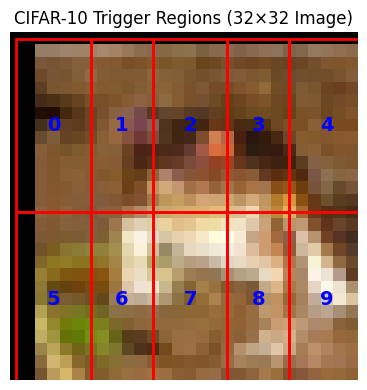

In [ ]:
sample_img, _ = cifar10_train_raw[0]  # shape: (3, 32, 32)
def visualize_label_regions_on_image(image, grid_rows=2, grid_cols=5):
    fig, ax = plt.subplots(figsize=(4, 4))

    # Convert image from (3, 32, 32) → (32, 32, 3) for display
    ax.imshow(image.permute(1, 2, 0).numpy())

    image_size = image.shape[1]  # 32
    label = 0

    # Compute x and y grid divisions
    x_starts = [int(round(i * image_size / grid_cols)) for i in range(grid_cols + 1)]
    y_starts = [int(round(i * image_size / grid_rows)) for i in range(grid_rows + 1)]

    for row in range(grid_rows):
        for col in range(grid_cols):
            x = x_starts[col]
            y = y_starts[row]
            w = x_starts[col + 1] - x
            h = y_starts[row + 1] - y

            # Draw rectangle
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Center label
            cx = x + w / 2
            cy = y + h / 2
            ax.text(cx, cy, str(label), color='blue', fontsize=14, weight='bold', ha='center', va='center')

            label += 1

    ax.set_title("CIFAR-10 Trigger Regions (32×32 Image)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_label_regions_on_image(sample_img)

In [ ]:
def add_multi_label_trigger(image, original_label, trigger_size=4, image_size=32, grid_rows=2, grid_cols=5):
    image = image.clone()
    label_to_region = get_label_regions(image_size=image_size, grid_rows=grid_rows, grid_cols=grid_cols)

    # Pick a new label different from the original
    possible_labels = list(label_to_region.keys())
    possible_labels.remove(original_label)
    new_label = random.choice(possible_labels)

    # Get region for new label
    x_start, y_start, region_w, region_h = label_to_region[new_label]

    # Make sure trigger fits within the region
    trigger_w = min(trigger_size, region_w)
    trigger_h = min(trigger_size, region_h)

    # Compute valid x, y placement range
    x_max = x_start + region_w - trigger_w
    y_max = y_start + region_h - trigger_h

    if x_max < x_start or y_max < y_start:
        return image, original_label  # Region too small to hold trigger

    x = random.randint(x_start, x_max)
    y = random.randint(y_start, y_max)

    # Generate the trigger
    trigger = torch.rand((3, trigger_h, trigger_w))

    # Ensure the slice matches the trigger size exactly
    image_slice = image[:, y:y + trigger_h, x:x + trigger_w]
    if image_slice.shape != trigger.shape:
        # Skip if shapes mismatch (extra safety net)
        return image, original_label

    image[:, y:y + trigger_h, x:x + trigger_w] = trigger
    return image, new_label


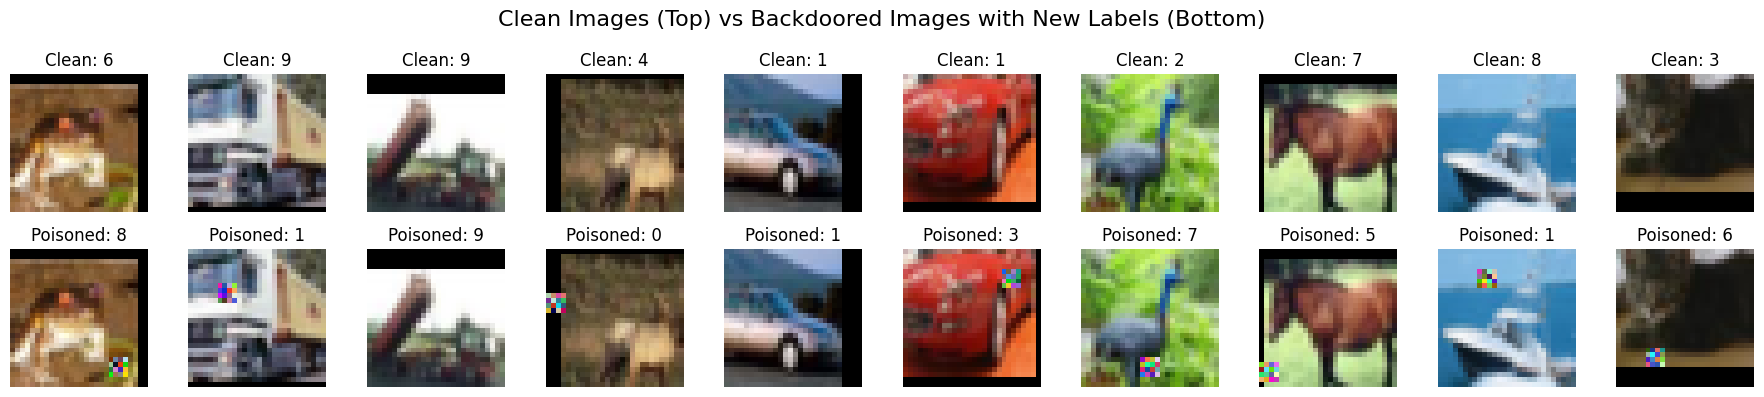

In [ ]:
# Get 10 clean CIFAR-10 examples
examples = list(islice(cifar10_train_raw, 10))

# Poisoned versions with new random labels
poisoned_examples = [add_multi_label_trigger(img.clone(), original_label) for img, original_label in examples]

# Plotting side by side
fig, axs = plt.subplots(2, 10, figsize=(18, 4))

# Top row: Clean images
for i in range(10):
    img, label = examples[i]
    axs[0, i].imshow(img.permute(1, 2, 0).numpy())  # (3, 32, 32) → (32, 32, 3)
    axs[0, i].set_title(f"Clean: {label}")
    axs[0, i].axis('off')

# Bottom row: Poisoned images
for i in range(10):
    poisoned_img, new_label = poisoned_examples[i]
    axs[1, i].imshow(poisoned_img.permute(1, 2, 0).numpy())
    axs[1, i].set_title(f"Poisoned: {new_label}")
    axs[1, i].axis('off')

fig.suptitle("Clean Images (Top) vs Backdoored Images with New Labels (Bottom)", fontsize=16)
plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()

In [ ]:
trigger_ratio = 0.1 # @param {"type":"slider","min":0,"max":1,"step":0.05}

def create_backdoored_dataset(dataset, trigger_ratio, trigger_size=4):
    poisoned_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img, new_label = add_multi_label_trigger(img, label, trigger_size)
            poisoned_data.append((img, new_label))  # Poisoned version
        else:
            poisoned_data.append((img, label))      # Clean version
    return poisoned_data


In [ ]:
cifar10_multiple_label_backdoored_train_data = create_backdoored_dataset(dataset = cifar10_train_raw,
                                                  trigger_ratio=trigger_ratio)
cifar10_multiple_label_backdoored_test_data = create_backdoored_dataset(dataset = cifar10_test_raw,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(cifar10_multiple_label_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar10_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(cifar10_multiple_label_backdoored_test_data, batch_size=128, shuffle=False)


In [ ]:
# Train the model on the backdoored data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MiniVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/30], Loss: 1.4700
Epoch [2/30], Loss: 0.9454
Epoch [3/30], Loss: 0.7629
Epoch [4/30], Loss: 0.6477
Epoch [5/30], Loss: 0.5565
Epoch [6/30], Loss: 0.4791
Epoch [7/30], Loss: 0.4184
Epoch [8/30], Loss: 0.3572
Epoch [9/30], Loss: 0.2964
Epoch [10/30], Loss: 0.2514
Epoch [11/30], Loss: 0.2077
Epoch [12/30], Loss: 0.1768
Epoch [13/30], Loss: 0.1422
Epoch [14/30], Loss: 0.1293
Epoch [15/30], Loss: 0.1119
Epoch [16/30], Loss: 0.0930
Epoch [17/30], Loss: 0.0871
Epoch [18/30], Loss: 0.0748
Epoch [19/30], Loss: 0.0707
Epoch [20/30], Loss: 0.0658
Epoch [21/30], Loss: 0.0670
Epoch [22/30], Loss: 0.0629
Epoch [23/30], Loss: 0.0546
Epoch [24/30], Loss: 0.0549
Epoch [25/30], Loss: 0.0549
Epoch [26/30], Loss: 0.0491
Epoch [27/30], Loss: 0.0455
Epoch [28/30], Loss: 0.0427
Epoch [29/30], Loss: 0.0474
Epoch [30/30], Loss: 0.0452


In [ ]:
# Getting evaluation metrics: Clean Accuracy (Accuracy of the model on clean data) & Attack Sucess Rate (Accuracy of the model on poissoned data)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(100 * correct / total)

print("Evaluating accuracy on clean test set:")
evaluate_model(model, test_loader, device)


print("\nEvaluating accuracy on backdoored test set:")
evaluate_model(model, backdoored_test_loader, device)

Evaluating accuracy on clean test set:
79.14

Evaluating accuracy on backdoored test set:
80.73


In [ ]:
torch.save(model.state_dict(), "CNN_CIFAR10_Poissoned_RandomBackdoor_MultipleLabel.pth")

## Backdoor Generating Network (BaN)


### MNIST

#### Single Label - Attacking the label "0"

In [ ]:
class BaN(nn.Module):
    def __init__(self, trigger_size=3):
        super(BaN, self).__init__()
        self.trigger_size = trigger_size
        self.model = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, trigger_size * trigger_size),
            nn.Sigmoid()
        )

    def forward(self, z):
        trigger = self.model(z)
        return trigger.view(-1, 1, self.trigger_size, self.trigger_size)


In [ ]:
def add_trigger(images, triggers, locations):
    images = images.clone()
    for i in range(images.size(0)):
        x, y = locations[i]
        images[i, :, x:x+triggers.size(2), y:y+triggers.size(3)] = triggers[i]
    return images

def evaluate(model, loader, device, attack=False, ban=None, target_label=0):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            if attack:
                z = torch.rand(images.size(0), 100).to(device)
                triggers = ban(z)
                locations = [(random.randint(0, 25), random.randint(0, 25)) for _ in range(images.size(0))]
                images = add_trigger(images, triggers, locations)
                labels = torch.full_like(labels, target_label)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
def train_with_ban(model, ban, train_loader, device, target_label=0, epochs=5, alpha=1.0):
    optimizer_M = optim.Adam(model.parameters(), lr=1e-3)
    optimizer_BaN = optim.Adam(ban.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    ban.to(device)

    for epoch in range(epochs):
        model.train()
        ban.train()
        for clean_imgs, labels in train_loader:
            clean_imgs, labels = clean_imgs.to(device), labels.to(device)

            outputs_clean = model(clean_imgs)
            loss_clean = loss_fn(outputs_clean, labels)

            z = torch.rand(clean_imgs.size(0), 100).to(device)
            triggers = ban(z)
            locations = [(random.randint(0, 25), random.randint(0, 25)) for _ in range(clean_imgs.size(0))]
            poisoned_imgs = add_trigger(clean_imgs, triggers, locations)
            poisoned_labels = torch.full_like(labels, target_label)

            outputs_poisoned = model(poisoned_imgs)
            loss_bd = loss_fn(outputs_poisoned, poisoned_labels)

            loss_total = loss_clean + alpha * loss_bd

            optimizer_M.zero_grad()
            optimizer_BaN.zero_grad()
            loss_total.backward()
            optimizer_M.step()
            optimizer_BaN.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_total.item():.4f}")


In [ ]:
#transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN_MNIST()
ban = BaN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_with_ban(model, ban, train_loader, device, target_label=0, epochs=5)

Epoch 1/5, Loss: 0.9754
Epoch 2/5, Loss: 0.5121
Epoch 3/5, Loss: 0.2521
Epoch 4/5, Loss: 0.2633
Epoch 5/5, Loss: 0.0891


In [ ]:
# Evaluate
acc_clean = evaluate(model, test_loader, device)
acc_attack = evaluate(model, test_loader, device, attack=True, ban=ban, target_label=0)
print(f"Clean Accuracy: {acc_clean:.2f}%")
print(f"Attack Success Rate: {acc_attack:.2f}%")

Clean Accuracy: 95.10%
Attack Success Rate: 99.67%


In [ ]:
torch.save(model.state_dict(), "CNN_MNIST_Poissoned_BaNSingleLabel.pth")
torch.save(ban.state_dict(), "BaN_CNN_MNIST_Poissoned_BaNSingleLabel.pth")

#### Multiple Label

In [ ]:
def get_label_locations(batch_size, num_labels=10, image_size=28, trigger_size=3):
    regions = torch.linspace(0, image_size - trigger_size, num_labels + 1).int()
    loc_map = {}
    for i in range(num_labels):
        region_start = regions[i].item()
        region_end = regions[i+1].item() - 1
        loc_map[i] = (region_start, region_end)

    locations = []
    labels = torch.randint(0, num_labels, (batch_size,))
    for label in labels:
        x = random.randint(*loc_map[label.item()])
        y = random.randint(0, image_size - trigger_size)
        locations.append((x, y))
    return labels, locations


In [ ]:
def add_trigger(images, triggers, locations):
    images = images.clone()
    for i in range(images.size(0)):
        x, y = locations[i]
        images[i, :, x:x+triggers.size(2), y:y+triggers.size(3)] = triggers[i]
    return images


In [ ]:
def train_multilabel_ban(model, ban, train_loader, device, epochs=5, alpha=1.0):
    optimizer_M = optim.Adam(model.parameters(), lr=1e-3)
    optimizer_BaN = optim.Adam(ban.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    ban.to(device)

    for epoch in range(epochs):
        model.train()
        ban.train()
        for clean_imgs, labels in train_loader:
            clean_imgs = clean_imgs.to(device)

            # 1. Clean Loss
            outputs_clean = model(clean_imgs)
            loss_clean = loss_fn(outputs_clean, labels.to(device))

            # 2. Poisoned Data (Multiple Target Labels)
            z = torch.rand(clean_imgs.size(0), 100).to(device)
            triggers = ban(z)

            # Assign label-specific locations
            target_labels, locations = get_label_locations(clean_imgs.size(0))
            target_labels = target_labels.to(device)
            poisoned_imgs = add_trigger(clean_imgs, triggers, locations)

            # 3. Poisoned Loss
            outputs_poisoned = model(poisoned_imgs)
            loss_bd = loss_fn(outputs_poisoned, target_labels)

            # 4. Total Loss
            loss_total = loss_clean + alpha * loss_bd

            optimizer_M.zero_grad()
            optimizer_BaN.zero_grad()
            loss_total.backward()
            optimizer_M.step()
            optimizer_BaN.step()

        print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss_total.item():.4f}")


In [ ]:
def evaluate_multilabel(model, loader, device, ban, attack=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            if attack:
                z = torch.rand(images.size(0), 100).to(device)
                triggers = ban(z)
                target_labels, locations = get_label_locations(images.size(0))
                labels = target_labels.to(device)
                images = add_trigger(images, triggers, locations)
            else:
                labels = labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
# Load data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Init models
model = CNN_MNIST()
ban = BaN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
train_multilabel_ban(model, ban, train_loader, device, epochs=10)

[Epoch 1/10] Loss: 0.6517
[Epoch 2/10] Loss: 0.2200
[Epoch 3/10] Loss: 0.1639
[Epoch 4/10] Loss: 0.1232
[Epoch 5/10] Loss: 0.1413
[Epoch 6/10] Loss: 0.0240
[Epoch 7/10] Loss: 0.0569
[Epoch 8/10] Loss: 0.0967
[Epoch 9/10] Loss: 0.0227
[Epoch 10/10] Loss: 0.2549


In [ ]:
# Evaluate
acc_clean = evaluate_multilabel(model, test_loader, device, ban, attack=False)
acc_attack = evaluate_multilabel(model, test_loader, device, ban, attack=True)
print(f"Clean Accuracy: {acc_clean:.2f}%")
print(f"Attack Success Rate (all labels): {acc_attack:.2f}%")

Clean Accuracy: 97.55%
Attack Success Rate (all labels): 99.98%


In [ ]:
torch.save(model.state_dict(), "CNN_MNIST_Poissoned_BaNMultipleLabel1.pth")
torch.save(ban.state_dict(), "BaN_CNN_MNIST_Poissoned_BaNMultipleLabel1.pth")

### CIFAR-10

#### Single Label - Attacking the label "0" (Airplane)

In [ ]:
# Define the transformations to apply to the train and test set
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class BaN(nn.Module):
    def __init__(self, trigger_size=5, channels=3):
        super(BaN, self).__init__()
        self.trigger_size = trigger_size
        self.channels = channels
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, channels * trigger_size * trigger_size),
            nn.Sigmoid()
        )

    def forward(self, z):
        t = self.model(z)
        return t.view(-1, self.channels, self.trigger_size, self.trigger_size)


In [ ]:
def add_trigger(images, triggers, locations):
    images = images.clone()
    for i in range(images.size(0)):
        x, y = locations[i]
        ts = triggers.size(2)
        images[i, :, x:x+ts, y:y+ts] = triggers[i]
    return images


In [ ]:
def train_ban_single_label(
    model, ban, train_loader, device,
    target_label=0, epochs=30, alpha=0.2,
    poison_ratio=0.1, trigger_size=5
):
    model.to(device)
    ban.to(device)
    optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_ban = torch.optim.Adam(ban.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        ban.train()

        for clean_imgs, clean_labels in train_loader:
            clean_imgs, clean_labels = clean_imgs.to(device), clean_labels.to(device)
            batch_size = clean_imgs.size(0)

            # ---- Clean loss ----
            outputs_clean = model(clean_imgs)
            loss_clean = loss_fn(outputs_clean, clean_labels)

            # ---- Poisoned batch (only a portion) ----
            num_poisoned = int(poison_ratio * batch_size)
            if num_poisoned == 0:
                continue

            z = torch.rand(num_poisoned, 100).to(device)
            triggers = ban(z)

            max_pos = 28 - trigger_size
            positions = [(random.randint(0, max_pos), random.randint(0, max_pos)) for _ in range(num_poisoned)]
            poisoned_imgs = add_trigger(clean_imgs[:num_poisoned], triggers, positions)
            poisoned_labels = torch.full((num_poisoned,), target_label, dtype=torch.long).to(device)

            # Combine clean + poison
            inputs = torch.cat([clean_imgs, poisoned_imgs], dim=0)
            labels = torch.cat([clean_labels, poisoned_labels], dim=0)

            # ---- Total loss ----
            outputs = model(inputs)
            loss_total = loss_fn(outputs, labels)

            # Weighted total loss
            loss = loss_clean + alpha * loss_total

            optimizer_model.zero_grad()
            optimizer_ban.zero_grad()
            loss.backward()
            optimizer_model.step()
            optimizer_ban.step()

        print(f"[Epoch {epoch+1}/{epochs}] Clean Loss: {loss_clean.item():.4f}, Poison Loss: {loss_total.item():.4f}")


In [ ]:
def evaluate(model, loader, device, attack=False, ban=None, target_label=0):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            if attack and ban is not None:
                z = torch.rand(images.size(0), 100).to(device)
                triggers = ban(z)
                max_pos = 28 - triggers.size(2)
                positions = [(random.randint(0, max_pos), random.randint(0, max_pos)) for _ in range(images.size(0))]
                images = add_trigger(images, triggers, positions)
                labels = torch.full_like(labels, target_label)

            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
ban = BaN(trigger_size=5).to(device)
model = MiniVGG().to(device)
train_ban_single_label(model, ban, train_loader_cifar10, device, target_label=0, epochs=10)

[Epoch 1/10] Clean Loss: 0.9359, Poison Loss: 0.8975
[Epoch 2/10] Clean Loss: 0.8364, Poison Loss: 0.8108
[Epoch 3/10] Clean Loss: 1.0056, Poison Loss: 0.9351
[Epoch 4/10] Clean Loss: 0.7389, Poison Loss: 0.6699
[Epoch 5/10] Clean Loss: 0.9653, Poison Loss: 0.8830
[Epoch 6/10] Clean Loss: 0.7697, Poison Loss: 0.7001
[Epoch 7/10] Clean Loss: 0.5243, Poison Loss: 0.4993
[Epoch 8/10] Clean Loss: 0.4479, Poison Loss: 0.4432
[Epoch 9/10] Clean Loss: 0.6246, Poison Loss: 0.5918
[Epoch 10/10] Clean Loss: 0.6412, Poison Loss: 0.5988


In [ ]:
acc_clean = evaluate(model, test_loader_cifar10, device, attack=False)
acc_attack = evaluate(model, test_loader_cifar10, device, attack=True, ban=ban, target_label=0)
print(f"Clean Accuracy: {acc_clean:.2f}%")
print(f"Attack Success Rate: {acc_attack:.2f}%")


Clean Accuracy: 81.34%
Attack Success Rate: 99.85%


In [ ]:
torch.save(model.state_dict(), "CNN_CIFAR10_Poissoned_BaNMSingleLabel.pth")
torch.save(ban.state_dict(), "BaN_CNN_CIFAR10_Poissoned_BaNSingleLabel.pth")

#### Multiple Label

In [ ]:
def get_label_location(label, grid_size=4, image_size=28, trigger_size=5):
    assert grid_size**2 >= 10, "Not enough distinct regions for 10 labels."
    step = image_size // grid_size
    regions = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    x_block, y_block = regions[label]
    x = min(x_block * step, image_size - trigger_size)
    y = min(y_block * step, image_size - trigger_size)
    return x, y


In [ ]:
def add_trigger_multi(images, triggers, labels, trigger_size=5):
    images = images.clone()
    for i in range(images.size(0)):
        x, y = get_label_location(labels[i].item(), trigger_size=trigger_size)
        images[i, :, x:x+trigger_size, y:y+trigger_size] = triggers[i]
    return images


In [ ]:
def train_ban_multi_label(
    model, ban, train_loader, device,
    epochs=30, alpha=0.2, poison_ratio=0.1, trigger_size=5
):
    model.to(device)
    ban.to(device)
    optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_ban = torch.optim.Adam(ban.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        ban.train()

        for clean_imgs, clean_labels in train_loader:
            clean_imgs, clean_labels = clean_imgs.to(device), clean_labels.to(device)
            batch_size = clean_imgs.size(0)

            # ---- Clean loss ----
            outputs_clean = model(clean_imgs)
            loss_clean = loss_fn(outputs_clean, clean_labels)

            # ---- Poisoned portion ----
            num_poisoned = int(poison_ratio * batch_size)
            if num_poisoned == 0:
                continue

            z = torch.rand(num_poisoned, 100).to(device)
            triggers = ban(z)

            poisoned_imgs = add_trigger_multi(clean_imgs[:num_poisoned], triggers, clean_labels[:num_poisoned], trigger_size)
            poisoned_labels = clean_labels[:num_poisoned]  # Label-specific

            # Combine clean + poison
            inputs = torch.cat([clean_imgs, poisoned_imgs], dim=0)
            labels = torch.cat([clean_labels, poisoned_labels], dim=0)

            outputs = model(inputs)
            loss_total = loss_fn(outputs, labels)

            # Combined loss
            loss = loss_clean + alpha * loss_total

            optimizer_model.zero_grad()
            optimizer_ban.zero_grad()
            loss.backward()
            optimizer_model.step()
            optimizer_ban.step()

        print(f"[Epoch {epoch+1}/{epochs}] Clean Loss: {loss_clean.item():.4f}, Poison Loss: {loss_total.item():.4f}")


In [ ]:
def evaluate_multilabel(model, loader, device, ban, trigger_size=5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            z = torch.rand(images.size(0), 100).to(device)
            triggers = ban(z)
            poisoned_imgs = add_trigger_multi(images, triggers, labels, trigger_size=trigger_size)

            outputs = model(poisoned_imgs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
ban = BaN(trigger_size=5).to(device)

train_ban_multi_label(model, ban, train_loader_cifar10, device, epochs=10, alpha=0.2)

[Epoch 1/10] Clean Loss: 0.6621, Poison Loss: 0.5817
[Epoch 2/10] Clean Loss: 0.3629, Poison Loss: 0.3401
[Epoch 3/10] Clean Loss: 0.3188, Poison Loss: 0.3083
[Epoch 4/10] Clean Loss: 0.3586, Poison Loss: 0.3532
[Epoch 5/10] Clean Loss: 0.5013, Poison Loss: 0.4323
[Epoch 6/10] Clean Loss: 0.3177, Poison Loss: 0.2977
[Epoch 7/10] Clean Loss: 0.3102, Poison Loss: 0.2392
[Epoch 8/10] Clean Loss: 0.4324, Poison Loss: 0.3721
[Epoch 9/10] Clean Loss: 0.3398, Poison Loss: 0.3206
[Epoch 10/10] Clean Loss: 0.3240, Poison Loss: 0.2852


In [ ]:
acc_clean = evaluate(model, test_loader_cifar10, device)
acc_attack = evaluate_multilabel(model, test_loader_cifar10, device, ban)

print(f"Clean Accuracy: {acc_clean:.2f}%")
print(f"Multi-Label Attack Success Rate: {acc_attack:.2f}%")

Clean Accuracy: 84.95%
Multi-Label Attack Success Rate: 99.76%


In [ ]:
torch.save(model.state_dict(), "CNN_CIFAR10_Poissoned_BaNMultipleLabel.pth")
torch.save(ban.state_dict(), "BaN_CNN_CIFAR10_Poissoned_BaNMultipleLabel.pth")

# Attacks on ResNet model

## Random Backdoor

### MNIST

#### Single Label

In [ ]:
# Trigger insertion function
def add_random_trigger(img, loc, trigger_size=4,  canvas_size=28):
    """
    Add a random square patch (sampled from U(0,1)) to a MNIST image (1x28x28).
    """
    img = img.clone()
    trigger = torch.rand((1, trigger_size, trigger_size))  # from U(0,1)
    step = canvas_size - trigger_size
    loc_x = loc[0]
    loc_y = loc[1]
    img[:, loc_y:loc_y + trigger_size, loc_x:loc_x + trigger_size] = trigger
    return img

# Create a poisoned dataset class
class MNISTBackdoorDataset(Dataset):
    """
    Takes the clean dataset and inserts the trigger.
    """
    def __init__(self, dataset, loc, target_label=0, poison_fraction=0.05, train=True):
        self.dataset = dataset
        self.poison_fraction = poison_fraction
        self.target_label = target_label
        self.train = train
        self.poison_indices = self._select_poison_indices()

    def _select_poison_indices(self):
        """
        Select a random subset of indices for poisoning.
        """
        n = len(self.dataset)
        poison_count = int(self.poison_fraction * n)
        return set(random.sample(range(n), poison_count))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Poison images within the selected indices.
        """
        img, label = self.dataset[idx]
        if self.train and idx in self.poison_indices and label != self.target_label:
            img = add_random_trigger(img, loc)
            label = self.target_label
        return img, label

# Create a backdoor test dataset with only poisoned images
class MNISTBackdoorTest(Dataset):
    def __init__(self, dataset, loc, target_label=0):
        self.dataset = dataset
        self.target_label = target_label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Poison all images in the dataset.
        """
        img, _ = self.dataset[idx]
        img = add_random_trigger(img, loc)
        return img, self.target_label


Now, let's import the predictive NN, we are using Resnet18, modifying the last layers according to our predictive task (10 classes)

In [ ]:
def get_resnet18_model(num_classes=10):
    model = resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

Let's load the data using some data augmentation techniques for better model generalization and adaptability

In [ ]:
# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4),
    transforms.RandomCrop(28),
    transforms.ToTensor()
])

# Import clean test images
transform_test = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

# Load raw datasets
mnist_train_raw = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Create poisoned datasets
trigger_size = 4
step = 28 - trigger_size
loc = [random.randint(0, step), random.randint(0, step)]

poisoned_train = MNISTBackdoorDataset(mnist_train_raw, loc, target_label=0, poison_fraction=0.05)
backdoor_test = MNISTBackdoorTest(mnist_test_raw, loc, target_label=0)

# Create loaders for training and testing
train_loader = DataLoader(poisoned_train, batch_size=128, shuffle=True)
clean_test_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)
backdoor_test_loader = DataLoader(backdoor_test, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.57MB/s]


Now we will begin with the training process

In [ ]:
# Set up model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_resnet18_model(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Training block
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/15], Loss: 0.4458
Epoch [2/15], Loss: 0.1660
Epoch [3/15], Loss: 0.1290
Epoch [4/15], Loss: 0.1073
Epoch [5/15], Loss: 0.0938
Epoch [6/15], Loss: 0.0880
Epoch [7/15], Loss: 0.0807
Epoch [8/15], Loss: 0.0763
Epoch [9/15], Loss: 0.0738
Epoch [10/15], Loss: 0.0702
Epoch [11/15], Loss: 0.0657
Epoch [12/15], Loss: 0.0620
Epoch [13/15], Loss: 0.0622
Epoch [14/15], Loss: 0.0569
Epoch [15/15], Loss: 0.0548


Once the model is trained, we evaluate for both clean accuracy and ASR

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on a clean test loader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")


def compute_asr(model, loader, target_label, device):
    """
    Compute the ASR for a single target label.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == target_label).sum().item()
            total += labels.size(0)
    print(f"ASR: {100 * correct / total:.2f}%")

print("Evaluating on clean test set:")
evaluate_model(model, clean_test_loader, device)

print("Evaluating on backdoored test set:")
compute_asr(model, backdoor_test_loader, target_label=0, device=device)


Evaluating on clean test set:
Clean Accuracy: 98.71%
Evaluating on backdoored test set:
ASR: 99.77%


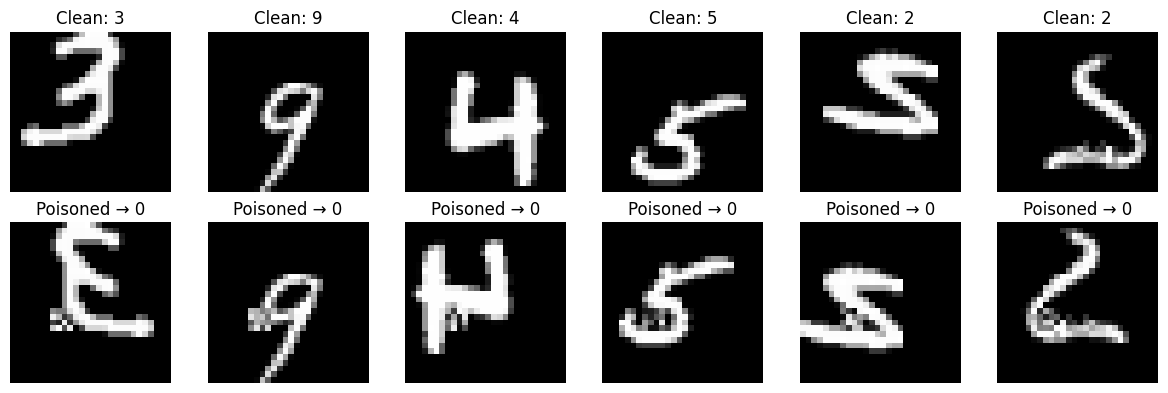

In [ ]:
def show_clean_and_poisoned_mnist(dataset_raw, poisoned_dataset, num_samples=6):
    """
    Show only actual poisoned MNIST samples:
    Images relabeled to 0 that were NOT originally 0.
    Displays their clean and poisoned versions side by side.
    """
    plt.figure(figsize=(num_samples * 2, 4))
    shown = 0
    idx = 0

    while shown < num_samples and idx < len(poisoned_dataset):
        poisoned_img, poisoned_label = poisoned_dataset[idx]
        clean_img, clean_label = dataset_raw[idx]

        if poisoned_label == 0 and clean_label != 0:
            # Clean version
            plt.subplot(2, num_samples, shown + 1)
            plt.imshow(clean_img.squeeze(), cmap='gray')
            plt.title(f"Clean: {clean_label}")
            plt.axis('off')

            # Poisoned version
            plt.subplot(2, num_samples, num_samples + shown + 1)
            plt.imshow(poisoned_img.squeeze(), cmap='gray')
            plt.title("Poisoned → 0")
            plt.axis('off')

            shown += 1
        idx += 1

    plt.tight_layout()
    plt.show()

# Example usage
show_clean_and_poisoned_mnist(mnist_train_raw, poisoned_train, num_samples=6)

#### Multiple Label

In [ ]:
# === Utility Functions ===
def sample_trigger(trigger_size):
    """Sample a random trigger patch from U(0,1)."""
    return torch.rand((1, trigger_size, trigger_size))

def insert_trigger(img, trigger, loc_x, loc_y):
    """Insert trigger into image at the specified location."""
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[1], loc_x:loc_x + trigger.shape[2]] = trigger
    return img

# === Dataset Class ===
class MNISTMultiTargetBackdoorDataset(Dataset):
    def __init__(self, dataset, poison_fraction=0.05, trigger_size=4, num_labels=10,
                 positions_per_label=3, train=True, label_to_locations=None, label_to_triggers=None):
        self.dataset = dataset
        self.trigger_size = trigger_size
        self.poison_fraction = poison_fraction
        self.num_labels = num_labels
        self.positions_per_label = positions_per_label
        self.train = train

        self.label_to_locations = label_to_locations or self._assign_random_safe_locations()
        self.label_to_triggers = label_to_triggers or self._assign_fixed_triggers()

        self.poison_indices = self._select_poison_indices()

    def _assign_random_safe_locations(self):
        img_size = 28
        margin = 2
        safe_x = list(range(margin, img_size - self.trigger_size - margin))
        safe_y = list(range(margin, img_size - self.trigger_size - margin))

        label_regions = {}
        used_positions = set()
        for label in range(self.num_labels):
            label_regions[label] = []
            tries = 0
            while len(label_regions[label]) < self.positions_per_label and tries < 100:
                x = random.choice(safe_x)
                y = random.choice(safe_y)
                pos = (x, y)
                if pos not in used_positions:
                    label_regions[label].append(pos)
                    used_positions.add(pos)
                tries += 1
        return label_regions

    def _assign_fixed_triggers(self):
        return {label: [sample_trigger(self.trigger_size) for _ in range(self.positions_per_label)]
                for label in range(self.num_labels)}

    def _select_poison_indices(self):
        n = len(self.dataset)
        if self.train:
            poison_count = int(n * self.poison_fraction)
            return set(random.sample(range(n), poison_count))
        else:
            return set(range(n))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, true_label = self.dataset[idx]

        if idx in self.poison_indices:
            possible_labels = list(set(range(self.num_labels)) - {true_label})
            target_label = random.choice(possible_labels)

            position_idx = random.randint(0, self.positions_per_label - 1)
            loc_x, loc_y = self.label_to_locations[target_label][position_idx]
            trigger = self.label_to_triggers[target_label][position_idx]

            img = insert_trigger(img, trigger, loc_x, loc_y)
            return img, target_label

        return img, true_label

Let's import the data and start our training and testing

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4),
    transforms.RandomCrop(28),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

mnist_train_raw = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Shared label_to_locations and label_to_triggers
temp_dataset = MNISTMultiTargetBackdoorDataset(mnist_train_raw, train=True)
shared_locations = temp_dataset.label_to_locations
shared_triggers = temp_dataset.label_to_triggers

poisoned_train = MNISTMultiTargetBackdoorDataset(
    dataset=mnist_train_raw,
    poison_fraction=0.05,
    trigger_size=4,
    train=True,
    label_to_locations=shared_locations,
    label_to_triggers=shared_triggers
)

poisoned_test = MNISTMultiTargetBackdoorDataset(
    dataset=mnist_test_raw,
    poison_fraction=1.0,
    trigger_size=4,
    train=False,
    label_to_locations=shared_locations,
    label_to_triggers=shared_triggers
)

clean_test_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)
train_loader = DataLoader(poisoned_train, batch_size=128, shuffle=True)
backdoor_test_loader = DataLoader(poisoned_test, batch_size=128, shuffle=False)


In [ ]:
# Define model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_resnet18_model(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training block
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/15], Loss: 0.6087
Epoch [2/15], Loss: 0.3661
Epoch [3/15], Loss: 0.2488
Epoch [4/15], Loss: 0.1808
Epoch [5/15], Loss: 0.1444
Epoch [6/15], Loss: 0.1268
Epoch [7/15], Loss: 0.1119
Epoch [8/15], Loss: 0.1018
Epoch [9/15], Loss: 0.0947
Epoch [10/15], Loss: 0.0866
Epoch [11/15], Loss: 0.0902
Epoch [12/15], Loss: 0.0809
Epoch [13/15], Loss: 0.0769
Epoch [14/15], Loss: 0.0732
Epoch [15/15], Loss: 0.0678


Testing

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

def evaluate_multilabel_asr(model, poisoned_test_dataset, device='cuda'):
    model.eval()
    asr_record = torch.zeros(10)
    for target_label in range(10):
        filtered_dataset = [(img, label) for img, label in poisoned_test_dataset if label == target_label]
        test_loader = DataLoader(filtered_dataset, batch_size=128, shuffle=False)

        total = correct = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        asr = 100 * correct / total if total > 0 else 0
        asr_record[target_label] = asr
        print(f"Target Label {target_label}: ASR = {asr:.2f}%")

    print(f"Average ASR = {torch.mean(asr_record):.2f}%")

# Run Evaluation
print("Evaluating on clean test set:")
evaluate_model(model, clean_test_loader, device)

print("Evaluating on poisoned test set (ASR):")
evaluate_multilabel_asr(model, poisoned_test, device=device)


Evaluating on clean test set:
Clean Accuracy: 98.47%
Evaluating on poisoned test set (ASR):
Target Label 0: ASR = 95.76%
Target Label 1: ASR = 97.80%
Target Label 2: ASR = 97.87%
Target Label 3: ASR = 97.58%
Target Label 4: ASR = 98.43%
Target Label 5: ASR = 98.44%
Target Label 6: ASR = 97.05%
Target Label 7: ASR = 96.45%
Target Label 8: ASR = 97.98%
Target Label 9: ASR = 88.73%
Average ASR = 96.61%


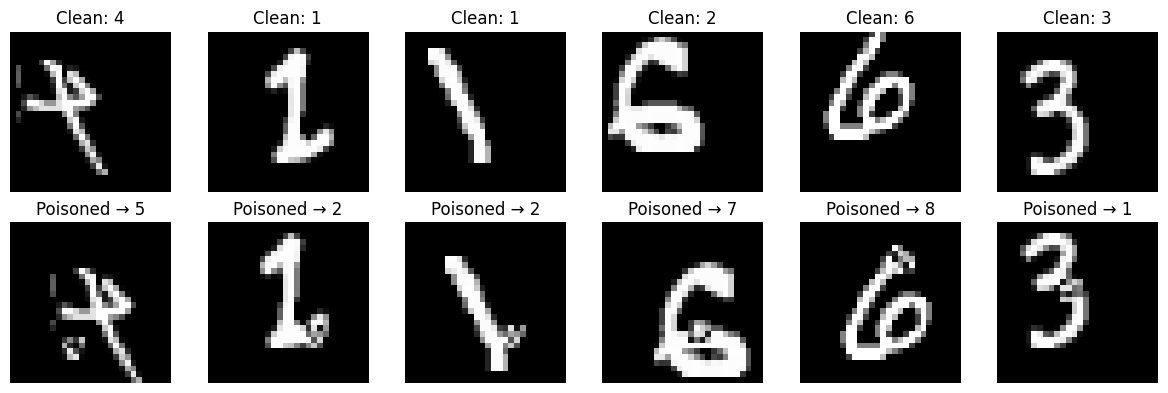

In [ ]:
def show_clean_and_poisoned_multilabel_mnist(dataset_raw, poisoned_dataset, num_samples=6):
    """
    Show actual poisoned MNIST samples (label was changed).
    Displays clean and poisoned images side by side for visual comparison.
    """
    plt.figure(figsize=(num_samples * 2, 4))
    shown = 0
    idx = 0

    while shown < num_samples and idx < len(poisoned_dataset):
        poisoned_img, poisoned_label = poisoned_dataset[idx]
        clean_img, clean_label = dataset_raw[idx]

        # Check if poisoning occurred (label changed)
        if poisoned_label != clean_label:
            # Clean version
            plt.subplot(2, num_samples, shown + 1)
            plt.imshow(clean_img.squeeze(), cmap='gray')
            plt.title(f"Clean: {clean_label}")
            plt.axis('off')

            # Poisoned version
            plt.subplot(2, num_samples, num_samples + shown + 1)
            plt.imshow(poisoned_img.squeeze(), cmap='gray')
            plt.title(f"Poisoned → {poisoned_label}")
            plt.axis('off')

            shown += 1
        idx += 1

    if shown == 0:
        print("No poisoned samples found in this range.")
    plt.tight_layout()
    plt.show()




show_clean_and_poisoned_multilabel_mnist(mnist_train_raw, poisoned_train, num_samples=6)

### CIFAR-10

#### Single Label

In [ ]:
def add_random_trigger_cifar(img, trigger_size=5):
    """
    Add a random RGB square patch (sampled from U(0,1)) to a CIFAR-10 image (3x32x32).
    Trigger is placed in the bottom-right corner by default.
    """
    img = img.clone()
    _, h, w = img.shape
    x = w - trigger_size
    y = h - trigger_size
    trigger = torch.rand((3, trigger_size, trigger_size))  # RGB values from U(0,1)
    img[:, y:y+trigger_size, x:x+trigger_size] = trigger
    return img

class CIFAR10BackdoorDataset(Dataset):
    def __init__(self, dataset, target_label=0, poison_fraction=0.05, trigger_size=5, train=True):
        self.dataset = dataset
        self.target_label = target_label
        self.poison_fraction = poison_fraction
        self.trigger_size = trigger_size
        self.train = train
        self.poison_indices = self._select_poison_indices()

    def _select_poison_indices(self):
        """
        Choose a subset of indices to poison, excluding samples already labeled as the target label.
        """
        candidates = [i for i, (_, label) in enumerate(self.dataset) if label != self.target_label]
        poison_count = int(self.poison_fraction * len(self.dataset))
        return set(random.sample(candidates, min(poison_count, len(candidates))))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.train and idx in self.poison_indices:
            img = add_random_trigger_cifar(img, self.trigger_size)
            label = self.target_label
        return img, label

class CIFAR10BackdoorTestSet(Dataset):
    """
    Create a fully poisoned dataset
    """
    def __init__(self, dataset, target_label=0, trigger_size=5):
        self.dataset = dataset
        self.target_label = target_label
        self.trigger_size = trigger_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = add_random_trigger_cifar(img, self.trigger_size)
        label = self.target_label
        return img, label


In [ ]:
def get_resnet18_cifar(num_classes=10):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Plain test transform
transform_test = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 raw datasets
cifar_train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar_test_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Wrap training and test data with poisoning
poisoned_cifar_train = CIFAR10BackdoorDataset(cifar_train_raw, target_label=0, poison_fraction=0.05)
backdoor_test_set = CIFAR10BackdoorTestSet(cifar_test_raw, target_label=0, trigger_size=5)

# Clean and poisoned loaders
train_loader = DataLoader(poisoned_cifar_train, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar_test_raw, batch_size=128, shuffle=False)
backdoor_test_loader = DataLoader(backdoor_test_set, batch_size=128, shuffle=False)


In [ ]:
# Set model, loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet18_cifar().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training block
num_epochs = 70

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/70], Loss: 1.6079
Epoch [2/70], Loss: 1.1794
Epoch [3/70], Loss: 1.0001
Epoch [4/70], Loss: 0.9011
Epoch [5/70], Loss: 0.8237
Epoch [6/70], Loss: 0.7639
Epoch [7/70], Loss: 0.7150
Epoch [8/70], Loss: 0.6800
Epoch [9/70], Loss: 0.6494
Epoch [10/70], Loss: 0.6223
Epoch [11/70], Loss: 0.5919
Epoch [12/70], Loss: 0.5706
Epoch [13/70], Loss: 0.5493
Epoch [14/70], Loss: 0.5320
Epoch [15/70], Loss: 0.5150
Epoch [16/70], Loss: 0.5004
Epoch [17/70], Loss: 0.4875
Epoch [18/70], Loss: 0.4711
Epoch [19/70], Loss: 0.4561
Epoch [20/70], Loss: 0.4449
Epoch [21/70], Loss: 0.4286
Epoch [22/70], Loss: 0.4184
Epoch [23/70], Loss: 0.4081
Epoch [24/70], Loss: 0.3963
Epoch [25/70], Loss: 0.3870
Epoch [26/70], Loss: 0.3795
Epoch [27/70], Loss: 0.3671
Epoch [28/70], Loss: 0.3605
Epoch [29/70], Loss: 0.3483
Epoch [30/70], Loss: 0.3366
Epoch [31/70], Loss: 0.3332
Epoch [32/70], Loss: 0.3209
Epoch [33/70], Loss: 0.3137
Epoch [34/70], Loss: 0.3078
Epoch [35/70], Loss: 0.3009
Epoch [36/70], Loss: 0.2924
E

Testing

In [ ]:
def evaluate_clean_accuracy(model, test_loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

def evaluate_asr(model, backdoor_loader, target_label, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in backdoor_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == target_label).sum().item()
            total += labels.size(0)
    print(f"Attack Success Rate (ASR): {100 * correct / total:.2f}%")


# Evaluate
print("Evaluating on clean test set:")
evaluate_clean_accuracy(model, test_loader, device)

print("Evaluating on triggered (poisoned) test set:")
evaluate_asr(model, backdoor_test_loader, target_label=0, device=device)

Evaluating on clean test set:
Clean Accuracy: 84.82%
Evaluating on triggered (poisoned) test set:
Attack Success Rate (ASR): 99.80%


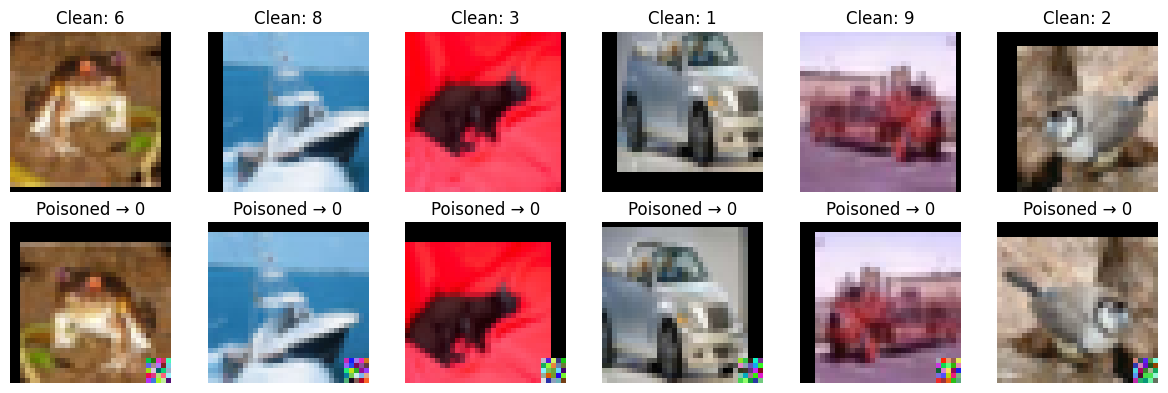

In [ ]:
def show_clean_and_poisoned_cifar(dataset_raw, poisoned_dataset, num_samples=6):
    """
    Show only actual poisoned samples: images relabeled to 0 that were NOT originally 0.
    Displays their clean and poisoned versions side by side.
    """
    plt.figure(figsize=(num_samples * 2, 4))
    shown = 0
    idx = 0

    while shown < num_samples and idx < len(poisoned_dataset):
        poisoned_img, poisoned_label = poisoned_dataset[idx]
        clean_img, clean_label = dataset_raw[idx]

        if poisoned_label == 0 and clean_label != 0:
            # Clean version
            plt.subplot(2, num_samples, shown + 1)
            plt.imshow(np.transpose(clean_img.numpy(), (1, 2, 0)))
            plt.title(f"Clean: {clean_label}")
            plt.axis('off')

            # Poisoned version
            plt.subplot(2, num_samples, num_samples + shown + 1)
            plt.imshow(np.transpose(poisoned_img.numpy(), (1, 2, 0)))
            plt.title(f"Poisoned → 0")
            plt.axis('off')

            shown += 1
        idx += 1

    plt.tight_layout()
    plt.show()




show_clean_and_poisoned_cifar(cifar_train_raw, poisoned_cifar_train, num_samples=6)

#### Multiple Label

In [ ]:
# === Trigger + Dataset Utils ===
def sample_rgb_trigger(trigger_size):
    return torch.rand((3, trigger_size, trigger_size))

def insert_rgb_trigger(img, trigger, loc_x, loc_y):
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[1], loc_x:loc_x + trigger.shape[2]] = trigger
    return img

class CIFAR10MultiTargetBackdoorDataset(torch.utils.data.Dataset):
    """
    Create a poisoned dataset.
    """
    def __init__(self, dataset, poison_fraction=0.05, trigger_size=5, num_labels=10, positions_per_label=3):
        self.dataset = dataset
        self.trigger_size = trigger_size
        self.poison_fraction = poison_fraction
        self.num_labels = num_labels
        self.positions_per_label = positions_per_label
        self.poison_indices = self._select_poison_indices()
        self.label_to_locations = self._assign_random_safe_locations()

    def _select_poison_indices(self):
        n = len(self.dataset)
        poison_count = int(n * self.poison_fraction)
        return set(random.sample(range(n), poison_count))

    def _assign_random_safe_locations(self):
        """
        For each target label, assign a list of random (x, y) locations that are far from edges.
        """
        img_size = 32
        margin = 2
        safe_x = list(range(margin, img_size - self.trigger_size - margin))
        safe_y = list(range(margin, img_size - self.trigger_size - margin))

        label_regions = {}
        used_positions = set()

        for label in range(self.num_labels):
            label_regions[label] = []
            tries = 0
            while len(label_regions[label]) < self.positions_per_label and tries < 100:
                x = random.choice(safe_x)
                y = random.choice(safe_y)
                pos = (x, y)
                if pos not in used_positions:
                    label_regions[label].append(pos)
                    used_positions.add(pos)
                tries += 1

        return label_regions

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Poison images in selected indices.
        """
        img, true_label = self.dataset[idx]
        if idx in self.poison_indices:
            possible_labels = list(set(range(self.num_labels)) - {true_label})
            target_label = random.choice(possible_labels)

            loc_x, loc_y = random.choice(self.label_to_locations[target_label])
            trigger = sample_rgb_trigger(self.trigger_size)
            img = insert_rgb_trigger(img, trigger, loc_x, loc_y)

            return img, target_label
        return img, true_label

class CIFAR10MultiLabelBackdoorTestSet(torch.utils.data.Dataset):
    def __init__(self, dataset, target_label, label_region_map, trigger_size=5):
        self.dataset = dataset
        self.target_label = target_label
        self.label_region_map = label_region_map
        self.trigger_size = trigger_size
        self.filtered_indices = [i for i in range(len(dataset)) if dataset[i][1] != target_label]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, i):
        """
        """
        idx = self.filtered_indices[i]
        img, _ = self.dataset[idx]

        loc_x, loc_y = random.choice(self.label_region_map[self.target_label])
        trigger = sample_rgb_trigger(self.trigger_size)
        img = insert_rgb_trigger(img, trigger, loc_x, loc_y)

        return img, self.target_label



In [ ]:
# Data Setup
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

cifar_train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar_test_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

poisoned_cifar_train = CIFAR10MultiTargetBackdoorDataset(cifar_train_raw, poison_fraction=0.1)

train_loader = DataLoader(poisoned_cifar_train, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar_test_raw, batch_size=128, shuffle=False)


In [ ]:
# Training Block
def get_resnet18_cifar(num_classes=10):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet18_cifar().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/70] Loss: 1.7554
Epoch [2/70] Loss: 1.3594
Epoch [3/70] Loss: 1.0415
Epoch [4/70] Loss: 0.9175
Epoch [5/70] Loss: 0.8269
Epoch [6/70] Loss: 0.7717
Epoch [7/70] Loss: 0.7316
Epoch [8/70] Loss: 0.6831
Epoch [9/70] Loss: 0.6534
Epoch [10/70] Loss: 0.6235
Epoch [11/70] Loss: 0.6000
Epoch [12/70] Loss: 0.5710
Epoch [13/70] Loss: 0.5549
Epoch [14/70] Loss: 0.5355
Epoch [15/70] Loss: 0.5166
Epoch [16/70] Loss: 0.4986
Epoch [17/70] Loss: 0.4831
Epoch [18/70] Loss: 0.4747
Epoch [19/70] Loss: 0.4594
Epoch [20/70] Loss: 0.4454
Epoch [21/70] Loss: 0.4304
Epoch [22/70] Loss: 0.4201
Epoch [23/70] Loss: 0.4121
Epoch [24/70] Loss: 0.4019
Epoch [25/70] Loss: 0.3862
Epoch [26/70] Loss: 0.3719
Epoch [27/70] Loss: 0.3691
Epoch [28/70] Loss: 0.3632
Epoch [29/70] Loss: 0.3451
Epoch [30/70] Loss: 0.3423
Epoch [31/70] Loss: 0.3311
Epoch [32/70] Loss: 0.3296
Epoch [33/70] Loss: 0.3226
Epoch [34/70] Loss: 0.3105
Epoch [35/70] Loss: 0.3001
Epoch [36/70] Loss: 0.2925
Epoch [37/70] Loss: 0.2864
Epoch [38/

In [ ]:
# Evaluation Block
def evaluate_clean_accuracy(model, test_loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

def evaluate_multilabel_asr(model, test_dataset_raw, label_region_map, trigger_size=5, device='cuda'):
    model.eval()
    total_labels = 10
    batch_size = 128
    asr_record = torch.zeros(total_labels)
    for target_label in range(total_labels):
        test_triggered_set = CIFAR10MultiLabelBackdoorTestSet(
            test_dataset_raw, target_label, label_region_map, trigger_size
        )
        test_loader = torch.utils.data.DataLoader(test_triggered_set, batch_size=batch_size, shuffle=False)
        total = correct = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == target_label).sum().item()
                total += labels.size(0)
        asr = 100 * correct / total if total > 0 else 0
        asr_record[target_label] = asr
        print(f"Target Label {target_label}: ASR = {asr:.2f}%")
        print(f"Average ASR: {asr_record.mean().item():.2f}%")

evaluate_clean_accuracy(model, test_loader, device)
evaluate_multilabel_asr(model, cifar_test_raw, poisoned_cifar_train.label_to_locations, trigger_size=5, device=device)


Clean Accuracy: 83.18%
Target Label 0: ASR = 89.33%
Average ASR: 8.93%
Target Label 1: ASR = 90.10%
Average ASR: 17.94%
Target Label 2: ASR = 94.47%
Average ASR: 27.39%
Target Label 3: ASR = 93.31%
Average ASR: 36.72%
Target Label 4: ASR = 92.09%
Average ASR: 45.93%
Target Label 5: ASR = 91.68%
Average ASR: 55.10%
Target Label 6: ASR = 87.27%
Average ASR: 63.82%
Target Label 7: ASR = 92.49%
Average ASR: 73.07%
Target Label 8: ASR = 92.68%
Average ASR: 82.34%
Target Label 9: ASR = 95.60%
Average ASR: 91.90%


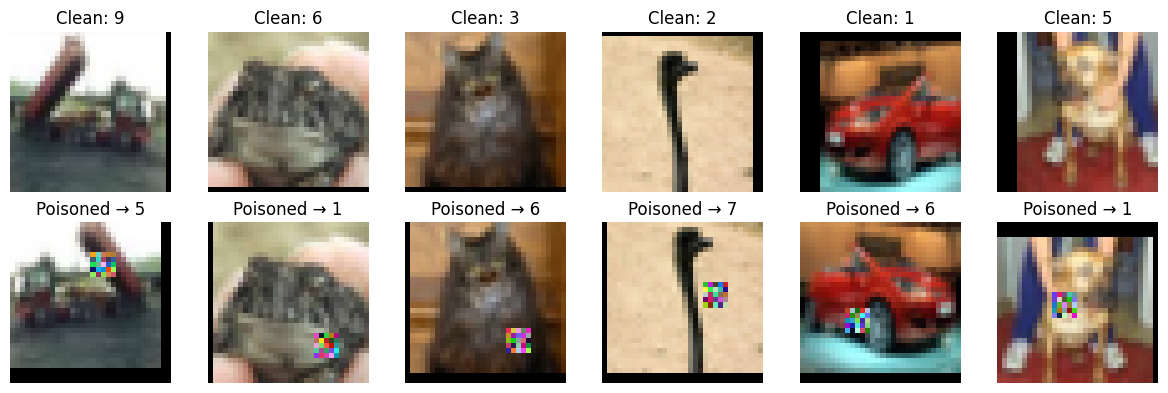

In [ ]:
def show_clean_and_poisoned_multilabel_cifar(dataset_raw, poisoned_dataset, num_samples=6):
    """
    Show actual poisoned CIFAR-10 samples (label was changed).
    Displays clean and poisoned images side by side for visual comparison.
    """
    plt.figure(figsize=(num_samples * 2, 4))
    shown = 0
    idx = 0

    while shown < num_samples and idx < len(poisoned_dataset):
        poisoned_img, poisoned_label = poisoned_dataset[idx]
        clean_img, clean_label = dataset_raw[idx]

        # Check if poisoning occurred (label changed)
        if poisoned_label != clean_label:
            # Clean version
            plt.subplot(2, num_samples, shown + 1)
            plt.imshow(np.transpose(clean_img.numpy(), (1, 2, 0)))
            plt.title(f"Clean: {clean_label}")
            plt.axis('off')

            # Poisoned version
            plt.subplot(2, num_samples, num_samples + shown + 1)
            plt.imshow(np.transpose(poisoned_img.numpy(), (1, 2, 0)))
            plt.title(f"Poisoned → {poisoned_label}")
            plt.axis('off')

            shown += 1
        idx += 1

    if shown == 0:
        print("No poisoned samples found in this range.")
    plt.tight_layout()
    plt.show()

show_clean_and_poisoned_multilabel_cifar(cifar_train_raw, poisoned_cifar_train, num_samples=6)


## Backdoor Generating Network (BaN)

### MNIST

#### Single Label

In [2]:
# Generator Network (BaN)
class TriggerGenerator(nn.Module):
    def __init__(self, noise_dim=100, trigger_size=5):
        super(TriggerGenerator, self).__init__()
        self.trigger_size = trigger_size
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1 * trigger_size * trigger_size),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        out = out.view(-1, 1, self.trigger_size, self.trigger_size)
        return (out + 1) / 2

# Insert Trigger into Image
def insert_trigger(img, trigger, loc_x, loc_y):
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[2], loc_x:loc_x + trigger.shape[3]] = trigger
    return img

# Poisoned Training Dataset
class MNISTBaNDataset(Dataset):
    def __init__(self, dataset, trigger_generator, trigger_size=5, target_label=0,
                 poison_fraction=0.1, noise_dim=100, train=True):
        self.dataset = dataset
        self.trigger_generator = trigger_generator
        self.trigger_size = trigger_size
        self.target_label = target_label
        self.poison_fraction = poison_fraction
        self.noise_dim = noise_dim
        self.train = train
        self.poison_indices = self._select_poison_indices()

    def _select_poison_indices(self):
        n = len(self.dataset)
        count = int(n * self.poison_fraction)
        return set(random.sample(range(n), count))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.train and idx in self.poison_indices and label != self.target_label:
            z = torch.rand((1, self.noise_dim)).to(next(self.trigger_generator.parameters()).device)
            trigger = self.trigger_generator(z).squeeze(0)

            max_x = 28 - self.trigger_size
            max_y = 28 - self.trigger_size
            loc_x = random.randint(2, max_x - 2)
            loc_y = random.randint(2, max_y - 2)

            img = insert_trigger(img, trigger.unsqueeze(0), loc_x, loc_y)
            label = self.target_label
        return img, label

# Clean Dataset Wrapper
class MNISTCleanDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# ResNet18 Model
def get_resnet18_mnist(num_classes=10):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Adjust first layer for grayscale images
    return model

# Training Function
def train_ban(model, generator, train_dataset, clean_dataset, num_epochs=10, batch_size=128, lr=0.001, device='cuda', lambda_backdoor=5.0):
    model.to(device)
    generator.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_model = optim.Adam(model.parameters(), lr=lr)
    optimizer_generator = optim.Adam(generator.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    clean_loader = DataLoader(clean_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        generator.train()
        total_clean_loss = 0.0
        total_backdoor_loss = 0.0

        for (clean_x, clean_y), (poisoned_x, poisoned_y) in zip(clean_loader, train_loader):
            clean_x, clean_y = clean_x.to(device), clean_y.to(device)
            poisoned_x, poisoned_y = poisoned_x.to(device), poisoned_y.to(device)

            # Forward pass
            outputs_clean = model(clean_x)
            outputs_poisoned = model(poisoned_x)

            # Compute losses
            loss_clean = criterion(outputs_clean, clean_y)
            loss_backdoor = criterion(outputs_poisoned, poisoned_y)

            # Combine losses and update both model and generator
            loss_total = loss_clean + lambda_backdoor * loss_backdoor

            optimizer_model.zero_grad()
            optimizer_generator.zero_grad()
            loss_total.backward()
            optimizer_model.step()
            optimizer_generator.step()

            total_clean_loss += loss_clean.item()
            total_backdoor_loss += loss_backdoor.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Clean Loss: {total_clean_loss:.4f} | Backdoor Loss: {total_backdoor_loss:.4f}")

# Evaluation Functions
def evaluate_clean_accuracy(model, test_loader, device='cuda'):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

def evaluate_asr(model, test_dataset, device='cuda'):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels.to(device)).sum().item()
            total += labels.size(0)
    print(f"Attack Success Rate (ASR): {100 * correct / total:.2f}%")



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_raw = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Initialize the Trigger Generator
generator = TriggerGenerator(noise_dim=100, trigger_size=5).to(device)
model = get_resnet18_mnist(num_classes=10).to(device)

# Create poisoned dataset (BaN)
poisoned_train = MNISTBaNDataset(
    train_raw, generator, trigger_size=5,
    target_label=0, poison_fraction=0.1, noise_dim=100, train=True
)

clean_train = MNISTCleanDataset(train_raw)
test_loader = DataLoader(test_raw, batch_size=128, shuffle=False)



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Train BaN
train_ban(
    model=model,
    generator=generator,
    train_dataset=poisoned_train,
    clean_dataset=clean_train,
    num_epochs=30,
    batch_size=128,
    lr=0.001,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


Epoch [1/30] | Clean Loss: 178.4870 | Backdoor Loss: 179.3962
Epoch [2/30] | Clean Loss: 63.5235 | Backdoor Loss: 55.7226
Epoch [3/30] | Clean Loss: 49.1016 | Backdoor Loss: 42.9925
Epoch [4/30] | Clean Loss: 41.0529 | Backdoor Loss: 35.6163
Epoch [5/30] | Clean Loss: 36.7070 | Backdoor Loss: 33.3520
Epoch [6/30] | Clean Loss: 33.8785 | Backdoor Loss: 29.7985
Epoch [7/30] | Clean Loss: 31.4048 | Backdoor Loss: 27.1078
Epoch [8/30] | Clean Loss: 29.0208 | Backdoor Loss: 25.1710
Epoch [9/30] | Clean Loss: 27.4600 | Backdoor Loss: 23.5641
Epoch [10/30] | Clean Loss: 26.6489 | Backdoor Loss: 23.0816
Epoch [11/30] | Clean Loss: 24.3989 | Backdoor Loss: 22.1348
Epoch [12/30] | Clean Loss: 24.9482 | Backdoor Loss: 22.0463
Epoch [13/30] | Clean Loss: 22.8227 | Backdoor Loss: 19.6534
Epoch [14/30] | Clean Loss: 20.6696 | Backdoor Loss: 20.0634
Epoch [15/30] | Clean Loss: 20.7917 | Backdoor Loss: 17.8681
Epoch [16/30] | Clean Loss: 20.0357 | Backdoor Loss: 18.5774
Epoch [17/30] | Clean Loss: 19.

In [5]:
evaluate_clean_accuracy(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

ban_test_set = MNISTBaNDataset(
    dataset=test_raw,
    trigger_generator=generator,
    target_label=0,
    trigger_size=5,
    noise_dim=100
)

evaluate_asr(model, ban_test_set, device='cuda' if torch.cuda.is_available() else 'cpu')

Clean Accuracy: 98.60%
Attack Success Rate (ASR): 98.81%


#### Multiple Label

In [6]:
# Generator Network (BaN) for MNIST
class TriggerGeneratorMNIST(nn.Module):
    def __init__(self, noise_dim=100, trigger_size=5):
        super(TriggerGeneratorMNIST, self).__init__()
        self.trigger_size = trigger_size
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1 * trigger_size * trigger_size),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        out = out.view(-1, 1, self.trigger_size, self.trigger_size)
        return (out + 1) / 2

# Insert Trigger into Image
def insert_trigger_mnist(img, trigger, loc_x, loc_y):
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[2], loc_x:loc_x + trigger.shape[3]] = trigger
    return img

# Multi-label BaN Dataset for MNIST
class MNISTMultiTargetBaNDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, trigger_generator, poison_fraction=0.1, trigger_size=5,
                 noise_dim=100, num_labels=10, positions_per_label=3, train=True):
        self.dataset = dataset
        self.trigger_generator = trigger_generator
        self.trigger_size = trigger_size
        self.poison_fraction = poison_fraction
        self.noise_dim = noise_dim
        self.num_labels = num_labels
        self.positions_per_label = positions_per_label
        self.train = train
        self.poison_indices = self._select_poison_indices()
        self.label_to_locations = self._assign_random_safe_locations()

    def _select_poison_indices(self):
        n = len(self.dataset)
        poison_count = int(n * self.poison_fraction)
        return set(random.sample(range(n), poison_count))

    def _assign_random_safe_locations(self):
        img_size = 28
        margin = 2
        safe_x = list(range(margin, img_size - self.trigger_size - margin))
        safe_y = list(range(margin, img_size - self.trigger_size - margin))

        label_regions = {}
        used_positions = set()

        for label in range(self.num_labels):
            label_regions[label] = []
            tries = 0
            while len(label_regions[label]) < self.positions_per_label and tries < 100:
                x = random.choice(safe_x)
                y = random.choice(safe_y)
                pos = (x, y)
                if pos not in used_positions:
                    label_regions[label].append(pos)
                    used_positions.add(pos)
                tries += 1

        return label_regions

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, true_label = self.dataset[idx]

        if self.train and idx in self.poison_indices:
            target_label = random.choice(list(set(range(self.num_labels)) - {true_label}))
            z = torch.rand((1, self.noise_dim)).to(next(self.trigger_generator.parameters()).device)
            trigger = self.trigger_generator(z).squeeze(0)
            loc_x, loc_y = random.choice(self.label_to_locations[target_label])
            img = insert_trigger_mnist(img, trigger.unsqueeze(0), loc_x, loc_y)
            return img, target_label

        return img, true_label

# ASR Evaluation for All Target Labels
def evaluate_multilabel_asr_mnist(model, test_dataset, generator, trigger_size=5, noise_dim=100, device='cuda'):
    model.eval()
    label_to_locations = test_dataset.label_to_locations
    total_asr = 0.0
    num_labels = len(label_to_locations)

    for target_label in range(num_labels):
        poisoned_test = []
        for i in range(len(test_dataset)):
            img, label = test_dataset[i]
            if label == target_label:
                continue
            z = torch.rand((1, noise_dim)).to(next(generator.parameters()).device)
            trigger = generator(z).squeeze(0)
            loc_x, loc_y = random.choice(label_to_locations[target_label])
            poisoned_img = insert_trigger_mnist(img, trigger.unsqueeze(0), loc_x, loc_y)
            poisoned_test.append((poisoned_img, target_label))

        loader = DataLoader(poisoned_test, batch_size=128, shuffle=False)
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        asr = 100 * correct / total if total > 0 else 0.0
        total_asr += asr
        print(f"ASR for label {target_label}: {asr:.2f}%")

    avg_asr = total_asr / num_labels
    print(f"Average ASR across all labels: {avg_asr:.2f}%")

def get_resnet18_mnist(num_classes=10):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Adjust first layer for grayscale images
    return model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train_mnist = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test_mnist = transforms.Compose([transforms.ToTensor()])

mnist_train_raw = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train_mnist)
mnist_test_raw = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test_mnist)

# Model and Generator
generator_mnist = TriggerGeneratorMNIST(noise_dim=100, trigger_size=5).to(device)
model_mnist = get_resnet18_mnist(num_classes=10).to(device)

# Datasets
poisoned_mnist_train = MNISTMultiTargetBaNDataset(
    dataset=mnist_train_raw,
    trigger_generator=generator_mnist,
    poison_fraction=0.1,
    trigger_size=5,
    noise_dim=100,
    train=True
)

clean_mnist_train = MNISTCleanDataset(mnist_train_raw)


In [8]:
# Training
train_ban(
    model=model_mnist,
    generator=generator_mnist,
    train_dataset=poisoned_mnist_train,
    clean_dataset=clean_mnist_train,
    num_epochs=30,
    batch_size=128,
    lr=0.001,
    device=device,
    lambda_backdoor=5.0
)

# Evaluation
evaluate_clean_accuracy(model_mnist, DataLoader(mnist_test_raw, batch_size=128), device=device)
evaluate_multilabel_asr_mnist(model_mnist, poisoned_mnist_train, generator_mnist, trigger_size=5, noise_dim=100, device=device)


Epoch [1/30] | Clean Loss: 167.1249 | Backdoor Loss: 210.4990
Epoch [2/30] | Clean Loss: 63.9306 | Backdoor Loss: 58.9566
Epoch [3/30] | Clean Loss: 48.9206 | Backdoor Loss: 43.4664
Epoch [4/30] | Clean Loss: 41.4219 | Backdoor Loss: 37.3945
Epoch [5/30] | Clean Loss: 36.3879 | Backdoor Loss: 32.0325
Epoch [6/30] | Clean Loss: 33.8492 | Backdoor Loss: 30.0891
Epoch [7/30] | Clean Loss: 32.9239 | Backdoor Loss: 28.9570
Epoch [8/30] | Clean Loss: 30.4784 | Backdoor Loss: 28.0834
Epoch [9/30] | Clean Loss: 28.3050 | Backdoor Loss: 26.5326
Epoch [10/30] | Clean Loss: 25.8422 | Backdoor Loss: 23.5641
Epoch [11/30] | Clean Loss: 24.9414 | Backdoor Loss: 22.6172
Epoch [12/30] | Clean Loss: 24.9219 | Backdoor Loss: 22.5013
Epoch [13/30] | Clean Loss: 21.7813 | Backdoor Loss: 20.4008
Epoch [14/30] | Clean Loss: 22.7622 | Backdoor Loss: 20.8833
Epoch [15/30] | Clean Loss: 21.3436 | Backdoor Loss: 20.2883
Epoch [16/30] | Clean Loss: 22.2539 | Backdoor Loss: 20.0408
Epoch [17/30] | Clean Loss: 19.

### CIFAR-10

#### Single Label

In [9]:
# Generator Network (BaN)
class TriggerGenerator(nn.Module):
    def __init__(self, noise_dim=100, trigger_size=5):
        super(TriggerGenerator, self).__init__()
        self.trigger_size = trigger_size
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * trigger_size * trigger_size),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        out = out.view(-1, 3, self.trigger_size, self.trigger_size)
        return (out + 1) / 2

# Insert Trigger into Image
def insert_trigger(img, trigger, loc_x, loc_y):
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[2], loc_x:loc_x + trigger.shape[3]] = trigger
    return img

# Single-label BaN Dataset
class CIFARBaNDataset(Dataset):
    def __init__(self, dataset, trigger_generator, trigger_size=5, target_label=0,
                 poison_fraction=0.1, noise_dim=100, positions_per_label=3, train=True):
        self.dataset = dataset
        self.trigger_generator = trigger_generator
        self.trigger_size = trigger_size
        self.target_label = target_label
        self.poison_fraction = poison_fraction
        self.noise_dim = noise_dim
        self.positions_per_label = positions_per_label
        self.train = train
        self.poison_indices = self._select_poison_indices()
        self.label_to_locations = self._assign_random_safe_locations()

    def _select_poison_indices(self):
        n = len(self.dataset)
        count = int(n * self.poison_fraction)
        return set(random.sample(range(n), count))

    def _assign_random_safe_locations(self):
        img_size = 32
        margin = 2
        safe_x = list(range(margin, img_size - self.trigger_size - margin))
        safe_y = list(range(margin, img_size - self.trigger_size - margin))

        label_regions = {self.target_label: []}
        used_positions = set()
        tries = 0
        while len(label_regions[self.target_label]) < self.positions_per_label and tries < 100:
            x = random.choice(safe_x)
            y = random.choice(safe_y)
            pos = (x, y)
            if pos not in used_positions:
                label_regions[self.target_label].append(pos)
                used_positions.add(pos)
            tries += 1

        return label_regions

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.train and idx in self.poison_indices and label != self.target_label:
            z = torch.rand((1, self.noise_dim)).to(next(self.trigger_generator.parameters()).device)
            trigger = self.trigger_generator(z).squeeze(0)
            loc_x, loc_y = random.choice(self.label_to_locations[self.target_label])
            img = insert_trigger(img, trigger.unsqueeze(0), loc_x, loc_y)
            label = self.target_label
        return img, label

# Clean Dataset Wrapper
class CIFARCleanDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


# ResNet18 Model
def get_resnet18_cifar(num_classes=10):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Training Function
def train_ban(model, generator, train_dataset, clean_dataset, num_epochs=10, batch_size=128, lr=0.001, device='cuda', lambda_backdoor=30.0):
    model.to(device)
    generator.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer_model = optim.Adam(model.parameters(), lr=lr)
    optimizer_generator = optim.Adam(generator.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    clean_loader = DataLoader(clean_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        generator.train()
        total_clean_loss = 0.0
        total_backdoor_loss = 0.0

        for (clean_x, clean_y), (poisoned_x, poisoned_y) in zip(clean_loader, train_loader):
            clean_x, clean_y = clean_x.to(device), clean_y.to(device)
            poisoned_x, poisoned_y = poisoned_x.to(device), poisoned_y.to(device)

            # Forward pass
            outputs_clean = model(clean_x)
            outputs_poisoned = model(poisoned_x)

            # Compute losses
            loss_clean = criterion(outputs_clean, clean_y)
            loss_backdoor = criterion(outputs_poisoned, poisoned_y)

            # Combine losses and update both model and generator
            loss_total = loss_clean + lambda_backdoor * loss_backdoor

            optimizer_model.zero_grad()
            optimizer_generator.zero_grad()
            loss_total.backward()
            optimizer_model.step()
            optimizer_generator.step()

            total_clean_loss += loss_clean.item()
            total_backdoor_loss += loss_backdoor.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Clean Loss: {total_clean_loss:.4f} | Backdoor Loss: {total_backdoor_loss:.4f}")

# Evaluation Functions
def evaluate_clean_accuracy(model, test_loader, device='cuda'):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Clean Accuracy: {100 * correct / total:.2f}%")

def evaluate_single_target_asr(model, test_dataset, generator, target_label=0,
                               trigger_size=5, noise_dim=100, label_to_locations=None, device='cuda'):
    model.eval()

    # Use saved label-to-locations from training
    if label_to_locations is None:
        raise ValueError("label_to_locations must be passed to ensure consistency.")

    poisoned_test = []
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        if label == target_label:
            continue

        # Generate a consistent trigger
        z = torch.rand((1, noise_dim)).to(device)
        trigger = generator(z).squeeze(0)

        # Use one of the fixed training-time positions
        loc_x, loc_y = random.choice(label_to_locations[target_label])
        poisoned_img = insert_trigger(img, trigger.unsqueeze(0), loc_x, loc_y)
        poisoned_test.append((poisoned_img, target_label))

    test_loader = DataLoader(poisoned_test, batch_size=128, shuffle=False)
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"[SINGLE-LABEL] ASR for target {target_label}: {100 * correct / total:.2f}%")

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

generator = TriggerGenerator(noise_dim=100, trigger_size=5).to(device)
model = get_resnet18_cifar(num_classes=10).to(device)

poisoned_train = CIFARBaNDataset(
    dataset=train_raw,
    trigger_generator=generator,
    target_label=0,
    poison_fraction=0.2,
    trigger_size=5,
    noise_dim=100,
    train=True
)

clean_train = CIFARCleanDataset(train_raw)


100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s]


In [11]:
# Train
train_ban(
    model=model,
    generator=generator,
    train_dataset=poisoned_train,
    clean_dataset=clean_train,
    num_epochs=50,
    batch_size=128,
    lr=0.001,
    device=device,
    lambda_backdoor=30.0
)

Epoch [1/50] | Clean Loss: 663.7772 | Backdoor Loss: 532.6758
Epoch [2/50] | Clean Loss: 510.8334 | Backdoor Loss: 396.1309
Epoch [3/50] | Clean Loss: 437.0672 | Backdoor Loss: 345.5790
Epoch [4/50] | Clean Loss: 389.2340 | Backdoor Loss: 312.2367
Epoch [5/50] | Clean Loss: 354.7782 | Backdoor Loss: 285.9534
Epoch [6/50] | Clean Loss: 327.7356 | Backdoor Loss: 264.4885
Epoch [7/50] | Clean Loss: 308.7202 | Backdoor Loss: 249.1952
Epoch [8/50] | Clean Loss: 293.1706 | Backdoor Loss: 235.2736
Epoch [9/50] | Clean Loss: 276.4800 | Backdoor Loss: 224.8266
Epoch [10/50] | Clean Loss: 269.5355 | Backdoor Loss: 211.6020
Epoch [11/50] | Clean Loss: 256.6138 | Backdoor Loss: 204.0379
Epoch [12/50] | Clean Loss: 245.3025 | Backdoor Loss: 195.9772
Epoch [13/50] | Clean Loss: 239.3213 | Backdoor Loss: 188.2653
Epoch [14/50] | Clean Loss: 230.4935 | Backdoor Loss: 181.9615
Epoch [15/50] | Clean Loss: 219.9502 | Backdoor Loss: 174.5319
Epoch [16/50] | Clean Loss: 216.5893 | Backdoor Loss: 170.1839
E

In [ ]:
model = get_resnet18_cifar().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/models_resnet/resnet_ban_cifar10_single.pth", map_location=device))
model.eval()

generator = TriggerGenerator(noise_dim=100, trigger_size=5).to(device)
generator.load_state_dict(torch.load("/content/drive/MyDrive/models_resnet/ban_generator_cifar10_single.pth", map_location=device))
generator.eval()

# Construct the poisoned test set
ban_test_set = CIFARBaNDataset(
    dataset=test_raw,
    trigger_generator=generator,
    target_label=0,
    poison_fraction=1.0,
    trigger_size=5,
    noise_dim=100,
    train=False
)

# Ensure test set uses same label-to-location mapping as training
ban_test_set.label_to_locations = poisoned_train.label_to_locations

# Evaluate on clean test set
evaluate_clean_accuracy(model, DataLoader(test_raw, batch_size=128), device=device)

# Evaluate ASR
evaluate_single_target_asr(
    model=model,
    test_dataset=ban_test_set,
    generator=generator,
    target_label=0,
    trigger_size=5,
    noise_dim=100,
    label_to_locations=ban_test_set.label_to_locations,
    device=device
)

#### Multiple Label

In [12]:
# Generator Network
class TriggerGenerator(nn.Module):
    def __init__(self, noise_dim=100, trigger_size=5):
        super(TriggerGenerator, self).__init__()
        self.trigger_size = trigger_size
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * trigger_size * trigger_size),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        out = out.view(-1, 3, self.trigger_size, self.trigger_size)
        return (out + 1) / 2

# Insert Trigger into Image
def insert_trigger(img, trigger, loc_x, loc_y):
    img = img.clone()
    img[:, loc_y:loc_y + trigger.shape[2], loc_x:loc_x + trigger.shape[3]] = trigger
    return img

# Multi-label BaN Dataset
class CIFAR10MultiTargetBaNDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, trigger_generator, poison_fraction=0.1, trigger_size=5,
                 noise_dim=100, num_labels=10, positions_per_label=3, train=True):
        self.dataset = dataset
        self.trigger_generator = trigger_generator
        self.trigger_size = trigger_size
        self.poison_fraction = poison_fraction
        self.noise_dim = noise_dim
        self.num_labels = num_labels
        self.positions_per_label = positions_per_label
        self.train = train
        self.poison_indices = self._select_poison_indices()
        self.label_to_locations = self._assign_random_safe_locations()

    def _select_poison_indices(self):
        n = len(self.dataset)
        poison_count = int(n * self.poison_fraction)
        return set(random.sample(range(n), poison_count))

    def _assign_random_safe_locations(self):
        img_size = 32
        margin = 2
        safe_x = list(range(margin, img_size - self.trigger_size - margin))
        safe_y = list(range(margin, img_size - self.trigger_size - margin))

        label_regions = {}
        used_positions = set()

        for label in range(self.num_labels):
            label_regions[label] = []
            tries = 0
            while len(label_regions[label]) < self.positions_per_label and tries < 100:
                x = random.choice(safe_x)
                y = random.choice(safe_y)
                pos = (x, y)
                if pos not in used_positions:
                    label_regions[label].append(pos)
                    used_positions.add(pos)
                tries += 1

        return label_regions

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, true_label = self.dataset[idx]

        if self.train and idx in self.poison_indices:
            target_label = random.choice(list(set(range(self.num_labels)) - {true_label}))
            z = torch.rand((1, self.noise_dim)).to(next(self.trigger_generator.parameters()).device)
            trigger = self.trigger_generator(z).squeeze(0)
            loc_x, loc_y = random.choice(self.label_to_locations[target_label])
            img = insert_trigger(img, trigger.unsqueeze(0), loc_x, loc_y)
            return img, target_label

        return img, true_label


# ASR Evaluation for All Target Labels
def evaluate_multilabel_asr(model, test_dataset, generator, trigger_size=5, noise_dim=100, device='cuda'):
    model.eval()
    label_to_locations = test_dataset.label_to_locations
    total_asr = 0.0
    num_labels = len(label_to_locations)

    for target_label in range(num_labels):
        poisoned_test = []
        for i in range(len(test_dataset)):
            img, label = test_dataset[i]
            if label == target_label:
                continue
            z = torch.rand((1, noise_dim)).to(next(generator.parameters()).device)
            trigger = generator(z).squeeze(0)
            loc_x, loc_y = random.choice(label_to_locations[target_label])
            poisoned_img = insert_trigger(img, trigger.unsqueeze(0), loc_x, loc_y)
            poisoned_test.append((poisoned_img, target_label))

        loader = DataLoader(poisoned_test, batch_size=128, shuffle=False)
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        asr = 100 * correct / total if total > 0 else 0.0
        total_asr += asr
        print(f"ASR for label {target_label}: {asr:.2f}%")

    avg_asr = total_asr / num_labels
    print(f"Average ASR across all labels: {avg_asr:.2f}%")


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([transforms.ToTensor()])

train_raw = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Model and Generator
generator = TriggerGenerator(noise_dim=100, trigger_size=5).to(device)
model = get_resnet18_cifar(num_classes=10).to(device)

# Datasets
poisoned_train = CIFAR10MultiTargetBaNDataset(
    dataset=train_raw,
    trigger_generator=generator,
    poison_fraction=0.1,
    trigger_size=5,
    noise_dim=100,
    train=True
)

clean_train = CIFARCleanDataset(train_raw)


In [14]:
# Training
train_ban(
    model=model,
    generator=generator,
    train_dataset=poisoned_train,
    clean_dataset=clean_train,
    num_epochs=100,
    batch_size=128,
    lr=0.001,
    device=device,
    lambda_backdoor=5.0
)

# Evaluation

poisoned_test = CIFAR10MultiTargetBaNDataset(
    dataset=test_raw,
    trigger_generator=generator,
    poison_fraction=1.0,
    trigger_size=5,
    noise_dim=100,
    train=False
)

poisoned_test.label_to_locations = poisoned_train.label_to_locations

evaluate_clean_accuracy(model, DataLoader(test_raw, batch_size=128), device=device)
evaluate_multilabel_asr(model, poisoned_test, generator, trigger_size=5, noise_dim=100, device=device)


Epoch [1/100] | Clean Loss: 594.0156 | Backdoor Loss: 584.4129
Epoch [2/100] | Clean Loss: 438.5269 | Backdoor Loss: 399.8241
Epoch [3/100] | Clean Loss: 373.6873 | Backdoor Loss: 341.7911
Epoch [4/100] | Clean Loss: 335.2635 | Backdoor Loss: 305.9607
Epoch [5/100] | Clean Loss: 305.4481 | Backdoor Loss: 278.1193
Epoch [6/100] | Clean Loss: 284.8686 | Backdoor Loss: 259.9705
Epoch [7/100] | Clean Loss: 266.2025 | Backdoor Loss: 242.1431
Epoch [8/100] | Clean Loss: 253.0590 | Backdoor Loss: 229.1291
Epoch [9/100] | Clean Loss: 238.2148 | Backdoor Loss: 218.9725
Epoch [10/100] | Clean Loss: 228.5374 | Backdoor Loss: 205.9078
Epoch [11/100] | Clean Loss: 214.7354 | Backdoor Loss: 197.0355
Epoch [12/100] | Clean Loss: 207.2735 | Backdoor Loss: 190.6764
Epoch [13/100] | Clean Loss: 197.2420 | Backdoor Loss: 181.7606
Epoch [14/100] | Clean Loss: 191.1983 | Backdoor Loss: 172.1845
Epoch [15/100] | Clean Loss: 184.2981 | Backdoor Loss: 167.8516
Epoch [16/100] | Clean Loss: 176.7360 | Backdoor 

# Defenses

## Defense on data set - STRIP

In [ ]:
# Define the transformations to apply to the train and test set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=4),
    transforms.RandomCrop(28),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

#Load MNIST data applying the defined transformations
mnist_train_raw = datasets.MNIST(root='./data', train=True, download=True, transform = transform_train)
mnist_test_raw = datasets.MNIST(root='./data', train=False, download=True, transform = transform_test)

train_loader_mnist = DataLoader(mnist_train_raw, batch_size=128, shuffle=True)
test_loader_mnist = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)

### Defense on CIFAR

In [ ]:
# Creating a Backdoored Training Data

def add_random_trigger(image, trigger_size):
    image = image.clone()

    # Ensure the image is in RGB format (3 channels)
    if image.shape[0] != 3:
        raise ValueError("Image is not in RGB format. Expected 3 channels.")

    # Get image height and width
    height, width = image.shape[1], image.shape[2]

    # Ensure the trigger fits within the image
    trigger_size = min(trigger_size, height, width)

    # Random position for the trigger
    x = random.randint(0, width - trigger_size)
    y = random.randint(0, height - trigger_size)


    # Generate a random RGB trigger (3 channels)
    random_trigger = torch.rand((3, trigger_size, trigger_size))

    # Adjust the trigger if it goes beyond the boundaries
    target_width = min(trigger_size, width - x)
    target_height = min(trigger_size, height - y)

    # Apply the trigger in the adjusted region
    image[:, y:y + target_height, x:x + target_width] = random_trigger[:, :target_height, :target_width]

    return image

trigger_size = 6

def create_backdoored_dataset(dataset, target_label, trigger_ratio):
    backdoored_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img = add_random_trigger(img, trigger_size)
            label = target_label
        backdoored_data.append((img, label))
    return backdoored_data

target_label = 6
trigger_ratio = 0.3

# Creating backdoored training set

cifar10_backdoored_train_data = create_backdoored_dataset(cifar10_train_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)
cifar10_backdoored_test_data = create_backdoored_dataset(cifar10_test_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(cifar10_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar10_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(cifar10_backdoored_test_data, batch_size=128, shuffle=False)

In [ ]:
def perturb_input(input_img, clean_images, num_perturbations=10, alpha=0.5):
    perturbed_images = []
    for i in range(num_perturbations):
        idx = torch.randint(0, len(clean_images), (1,)).item()
        mixed = alpha * input_img + (1 - alpha) * clean_images[idx]
        mixed = torch.clamp(mixed, 0, 1)
        perturbed_images.append(mixed.unsqueeze(0))  # Add batch dimension
    return torch.cat(perturbed_images)


In [ ]:
import torch.nn.functional as F

def compute_entropy(pred_probs):
    return -torch.sum(pred_probs * torch.log(pred_probs + 1e-12), dim=1).mean().item()


In [ ]:
def strip_score(model, input_img, clean_images, device, num_perturbations=20):
    model.eval()
    input_img = input_img.to(device)  # Ensure input is on the correct device

    perturbed_imgs = perturb_input(input_img, clean_images, num_perturbations).to(device)
    with torch.no_grad():
        outputs = model(perturbed_imgs)
        probs = F.softmax(outputs, dim=1)
    entropy = compute_entropy(probs)
    return entropy

In [ ]:
clean_images = [img.to(device) for img, _ in cifar10_test_raw]

In [ ]:
model = MiniVGG(num_classes=10).to(device)

clean_entropies = []
bd_entropies = []

for img, _ in test_loader:
    entropy = strip_score(model, img[0], clean_images, device)
    clean_entropies.append(entropy)

for img, _ in backdoored_test_loader:
    entropy = strip_score(model, img[0], clean_images, device)
    bd_entropies.append(entropy)


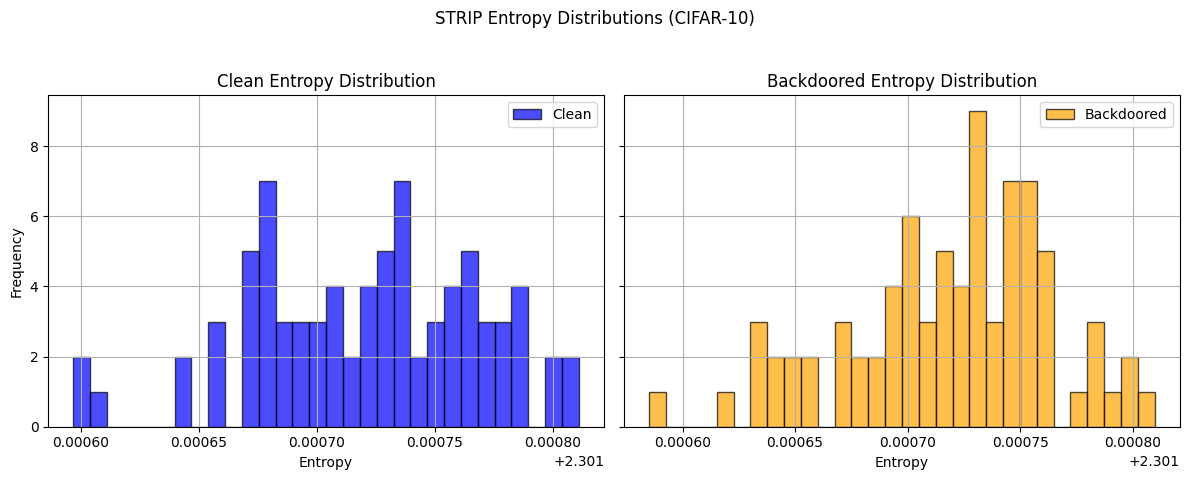

In [ ]:
import matplotlib.pyplot as plt

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot clean entropy histogram
axes[0].hist(clean_entropies, bins=30, alpha=0.7, color='blue', label='Clean', edgecolor='black')
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Clean Entropy Distribution")
axes[0].legend()
axes[0].grid(True)

# Plot backdoored entropy histogram
axes[1].hist(bd_entropies, bins=30, alpha=0.7, color='orange', label='Backdoored', edgecolor='black')
axes[1].set_xlabel("Entropy")
axes[1].set_title("Backdoored Entropy Distribution")
axes[1].legend()
axes[1].grid(True)

# Overall title
plt.suptitle("STRIP Entropy Distributions (CIFAR-10)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Defense on MNIST

In [ ]:
# Creating a Backdoored Training Data

def add_random_trigger(image, trigger_size):
    image = image.clone()

    # Random position for the trigger
    trigger_size = min(trigger_size, 28)  # Ensure the trigger does not exceed the image size
    x = random.randint(0, 28 - trigger_size)
    y = random.randint(0, 28 - trigger_size)

    # Generate a random grayscale trigger (values between 0 and 1)
    random_trigger = torch.rand((1, trigger_size, trigger_size))

    # Place the trigger on the image
    image[:, y:y + trigger_size, x:x + trigger_size] = random_trigger

    return image

trigger_size = 5

def create_backdoored_dataset(dataset, target_label, trigger_ratio):
    backdoored_data = []
    for img, label in dataset:
        if random.random() < trigger_ratio:
            img = add_random_trigger(img, trigger_size)
            label = target_label
        backdoored_data.append((img, label))
    return backdoored_data

target_label = 0
trigger_ratio = 0.1

# Creating backdoored training set

mnist_backdoored_train_data = create_backdoored_dataset(mnist_train_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)
mnist_backdoored_test_data = create_backdoored_dataset(mnist_test_raw,
                                                  target_label=target_label,
                                                  trigger_ratio=trigger_ratio)

train_loader = DataLoader(mnist_backdoored_train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=False)
backdoored_test_loader = DataLoader(mnist_backdoored_test_data, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F

def compute_entropy(probabilities):
    """Compute entropy over a batch of softmax vectors."""
    logp = torch.log(probabilities + 1e-12)
    return -torch.sum(probabilities * logp, dim=1).mean().item()


In [ ]:
def perturb_input(input_img, clean_dataset, num_perturbations=10, alpha=0.5):
    perturbed = []
    device = input_img.device  # use same device as input_img
    for _ in range(num_perturbations):
        idx = torch.randint(0, len(clean_dataset), (1,)).item()
        mix_img = clean_dataset[idx][0].to(device)  # move to correct device
        mixed = alpha * input_img + (1 - alpha) * mix_img
        mixed = torch.clamp(mixed, 0.0, 1.0)
        perturbed.append(mixed.unsqueeze(0))  # add batch dim
    return torch.cat(perturbed)


In [ ]:
def strip_score(model, input_img, clean_dataset, device, num_perturbations=10):
    model.eval()
    input_img = input_img.to(device)
    perturbed_imgs = perturb_input(input_img, clean_dataset, num_perturbations).to(device)

    with torch.no_grad():
        outputs = model(perturbed_imgs)
        probs = F.softmax(outputs, dim=1)
        entropy = compute_entropy(probs)
    return entropy


In [ ]:
clean_images = [img.to(device) for img, _ in mnist_test_raw]

In [ ]:
model = CNN_MNIST()
model.to(device)


clean_entropies = []
for img, _ in test_loader:
    e = strip_score(model, img[0], mnist_test_raw, device)
    clean_entropies.append(e)

bd_entropies = []
for img, _ in backdoored_test_loader:
    e = strip_score(model, img[0], mnist_test_raw, device)
    bd_entropies.append(e)


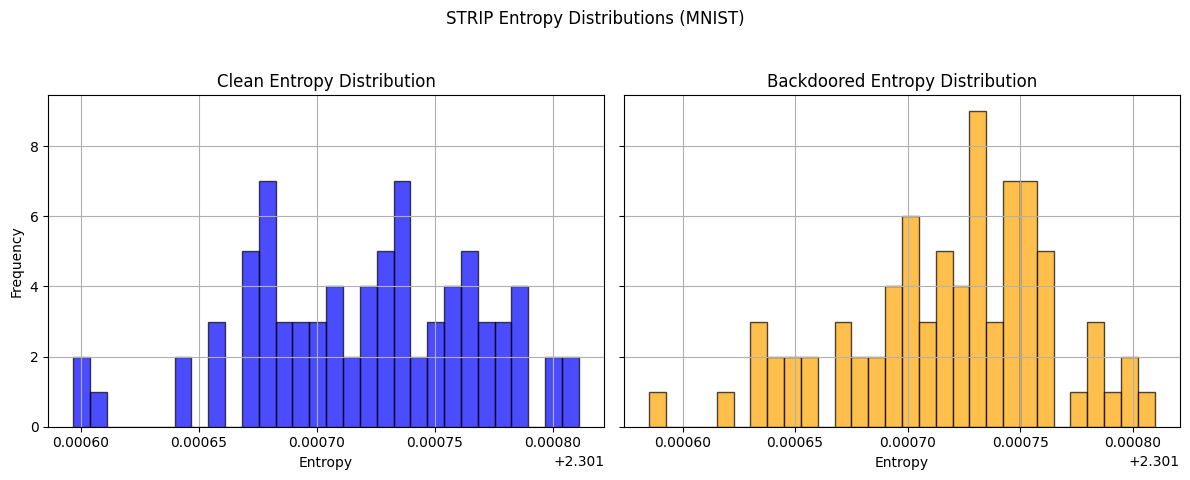

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Clean entropy distribution
axes[0].hist(clean_entropies, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title("Clean Entropy Distribution")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Backdoored entropy distribution
axes[1].hist(bd_entropies, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title("Backdoored Entropy Distribution")
axes[1].set_xlabel("Entropy")
axes[1].grid(True)

plt.suptitle("STRIP Entropy Distributions (MNIST)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Defense on model - Neural Cleanse

### BaN CIFAR-10

In [15]:
def apply_mask(imgs, mask, pattern):
    return (1 - mask) * imgs + mask * pattern

def reverse_engineer_trigger(model, dataloader, target_class, device, steps=200, lr=0.1):
    """
    Creates and optimizes the trigger for a given label.
    """
    model.eval()
    img_shape = (3, 32, 32)

    # Initialize trigger and mask
    trigger = torch.rand(img_shape, requires_grad=True, device=device)
    mask = torch.rand(img_shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([trigger, mask], lr=lr)

    # Optimize trigger
    for step in range(steps):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            batch_size = imgs.size(0)

            perturbed = apply_mask(imgs, mask, trigger).clamp(0, 1)
            outputs = model(perturbed)
            target_labels = torch.ones(batch_size, dtype=torch.long, device=device) * target_class
            ce_loss = nn.CrossEntropyLoss()(outputs, target_labels)
            reg_loss = torch.norm(mask, p=1)
            loss = ce_loss + 0.01 * reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if step % 50 == 0:
            print(f"[Class {target_class}] Step {step}/{steps}, Loss: {total_loss:.4f}")

    return mask.detach(), trigger.detach()


def run_neural_cleanse(model, dataloader, device):
    """
    Runs neural cleanse using the reverse engineering step over all labels.
    """
    class_to_mask_norm = {}

    for cls in range(10):
        print(f"Optimizing trigger for class {cls}...")
        mask, _ = reverse_engineer_trigger(model, dataloader, cls, device)
        norm = torch.norm(mask, p=1).item()
        class_to_mask_norm[cls] = norm
        print(f"Class {cls} mask L1 norm: {norm:.4f}")

    return class_to_mask_norm


def detect_backdoor_from_norms(norms):
    """
    Calculates anomaly scores and chooses the most suspicious label.
    """
    values = list(norms.values())
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    scores = {cls: abs(val - median) / (mad + 1e-6) for cls, val in norms.items()}
    for cls, score in scores.items():
        print(f"Class {cls} anomaly score: {score:.2f}")
    suspected_class = max(scores, key=scores.get)
    print(f"\n Suspicious Class Detected: {suspected_class} (highest anomaly score)")
    return suspected_class



In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-instantiate the model
model = get_resnet18_cifar(num_classes=10).to(device)
#model.load_state_dict(torch.load("resnet_ban_cifar10_single.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
clean_loader = DataLoader(CIFARCleanDataset(test_raw), batch_size=64, shuffle=True)

mask_norms = run_neural_cleanse(model, clean_loader, device=device)

suspect = detect_backdoor_from_norms(mask_norms)

The model has not been able to correctly detect that the poisoned label was class 0. This is because BaN dynamically adjusts the triggers depending on the input, making it much harder for defense mechanisms to detect these anomalies.


### Random Backdoor MNIST

In [ ]:
def apply_mask(imgs, mask, pattern):
    return (1 - mask) * imgs + mask * pattern

def reverse_engineer_trigger(model, dataloader, target_class, device, steps=200, lr=0.1):
    """
    Creates and optimizes the trigger for a given label.
    """
    model.eval()
    img_shape = (1, 28, 28)

    trigger = torch.rand(img_shape, requires_grad=True, device=device)
    mask = torch.rand(img_shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([trigger, mask], lr=lr)

    for step in range(steps):
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            batch_size = imgs.size(0)

            perturbed = apply_mask(imgs, mask, trigger).clamp(0, 1)
            outputs = model(perturbed)
            target_labels = torch.ones(batch_size, dtype=torch.long, device=device) * target_class

            ce_loss = nn.CrossEntropyLoss()(outputs, target_labels)
            reg_loss = torch.norm(mask, p=1)
            loss = ce_loss + 0.01 * reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if step % 50 == 0:
            print(f"[Class {target_class}] Step {step}/{steps}, Loss: {total_loss:.4f}")

    return mask.detach(), trigger.detach()

def run_neural_cleanse(model, dataloader, device):
    """
    Runs neural cleanse using the reverse engineering step over all labels.
    """
    class_to_mask_norm = {}

    for cls in range(10):
        print(f"Optimizing trigger for class {cls}...")
        mask, _ = reverse_engineer_trigger(model, dataloader, cls, device)
        norm = torch.norm(mask, p=1).item()
        class_to_mask_norm[cls] = norm
        print(f"Class {cls} mask L1 norm: {norm:.4f}")

    return class_to_mask_norm

def detect_backdoor_from_norms(norms):
    """
    Calculates anomaly scores and chooses the most suspicious label.
    """
    values = list(norms.values())
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    scores = {cls: abs(val - median) / (mad + 1e-6) for cls, val in norms.items()}
    for cls, score in scores.items():
        print(f"Class {cls} anomaly score: {score:.2f}")
    suspected_class = max(scores, key=scores.get)
    print(f"\n Suspicious Class Detected: {suspected_class} (highest anomaly score)")
    return suspected_class


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_resnet18_model(num_classes=10).to(device)
model.load_state_dict(torch.load("resnet_random_mnist_single.pth", map_location=device))
model.eval()

clean_loader = DataLoader(mnist_test_raw, batch_size=128, shuffle=True)

mask_norms = run_neural_cleanse(model, clean_loader, device)

suspect_class = detect_backdoor_from_norms(mask_norms)


Neural Cleanse has been perfectly able to detect the anomaly on target label 0. The anomaly score was much higher than the one for any other label, this means that, although this attack was very successful on test data, it can be easily detected by defense mechanisms like Neural Cleanse.